# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we start the predictive analysis using machine and deep learning techniques.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Load the Dataset

As a first step we reload the full dataset used for the EDA:

In [4]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda.csv')

# drop the first solution (too correlated to the output: should be in the test set)
df_0 = df.loc[df['solutions'] == 0]
df   = df.loc[df['solutions'] != 0]

## Validation Strategy

We then retain 10% of the total dataset as test set (that means that we may have to keep less unique solutions than that).
We then use a linear model to determine the best tradeoff between the size of the validation set and the MSE.
As we did before, we split the unique solutions into the sets and only then assign the corresponding samples.

In [5]:
from sklearn.model_selection import train_test_split

sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, test_size=0.1, shuffle=True, random_state=RAND)

# divide into training and test set
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

# add solutions = 0 in the test set
#df_test = pd.concat([df_0, df_test], axis=0)

Define the linear model to be used:

In [6]:
import os
os.makedirs('./models', exist_ok=True)

In [7]:
from sklearn.linear_model import LinearRegression
import joblib

estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)

# save the model to file
joblib.dump(estimator, './models/lr_valsize.pkl')

['./models/lr_valsize.pkl']

Train the model on different splits of the validation set and compute the MSE:

In [8]:
import json
import numpy as np

val_sizes = np.linspace(0.1, 0.9, 17)
errors    = []

for size in val_sizes:
    
    print('Training ratio: {:.2f}'.format(size))

    sol_train_tmp, sol_val_tmp = train_test_split(sol_train, test_size=size, shuffle=False)

    # define the sets
    df_train_tmp = df_train.loc[df_train['solutions'].isin(sol_train_tmp)].sample(frac=1, random_state=RAND)
    df_val_tmp   = df_train.loc[df_train['solutions'].isin(sol_val_tmp)].sample(frac=1, random_state=RAND)

    exp_train_tmp = df_train_tmp['exp']
    exp_val_tmp   = df_val_tmp['exp']

    df_train_tmp = df_train_tmp.drop(columns=['solutions', 'init', 'exp'])
    df_val_tmp   = df_val_tmp.drop(columns=['solutions', 'init', 'exp'])

    # save the sets to file
    exp_train_tmp.to_csv('./data/lr_valsize_lab_train_tmp.csv', index=False)
    exp_val_tmp.to_csv('./data/lr_valsize_lab_val_tmp.csv', index=False)
    df_train_tmp.to_csv('./data/lr_valsize_train_tmp.csv', index=False)
    df_val_tmp.to_csv('./data/lr_valsize_val_tmp.csv', index=False)

    # train the estimator
    !python3 ./scripts/scikit-train.py -t './data/lr_valsize_train_tmp.csv' \
                                       -l './data/lr_valsize_lab_train_tmp.csv' \
                                       -e './models/lr_valsize.pkl'

    # compute metrics and predictions
    !python3 ./scripts/scikit-predict.py -t './data/lr_valsize_train_tmp.csv' \
                                         -l './data/lr_valsize_lab_train_tmp.csv' \
                                         -e './models/lr_valsize.pkl' \
                                         -o 'lr_valsize_train'
    
    !python3 ./scripts/scikit-predict.py -t './data/lr_valsize_val_tmp.csv' \
                                         -l './data/lr_valsize_lab_val_tmp.csv' \
                                         -e './models/lr_valsize.pkl' \
                                         -o 'lr_valsize_val'

    # read the metrics file
    with open('./metrics/lr_valsize_train.json', 'r') as f:
        metrics_train = json.load(f)
    with open('./metrics/lr_valsize_val.json', 'r') as f:
        metrics_val = json.load(f)

    errors.append((size, np.round(metrics_train['MSE'], 3), np.round(metrics_val['MSE'], 3)))

# save the errors to file
errors = pd.DataFrame(errors, columns=['size', 'training', 'validation'])
errors.to_csv('./metrics/lr_valsize_mse.csv', index=False)

Training ratio: 0.10
LinearRegression trained in 0.002 seconds.
LinearRegression predicted in 0.007 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.15
LinearRegression trained in 0.002 seconds.
LinearRegression predicted in 0.003 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.20
LinearRegression trained in 0.002 seconds.
LinearRegression predicted in 0.009 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.25
LinearRegression trained in 0.002 seconds.
LinearRegression predicted in 0.001 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.30
LinearRegression trained in 0.001 seconds.
LinearRegression predicted in 0.001 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.35
LinearRegression trained in 0.001 seconds.
LinearRegression predicted in 0.001 seconds.
LinearRegression predicted in 0.001 seconds.
Training ratio: 0.40
LinearRegression trained in 0.001 seconds.
LinearRegres

In [9]:
INPUT  = './metrics/lr_valsize_mse.csv'
OUTPUT = 'valsize_errors'

!python3 ./scripts/val_size_errors.py --errors {INPUT} --output {OUTPUT}

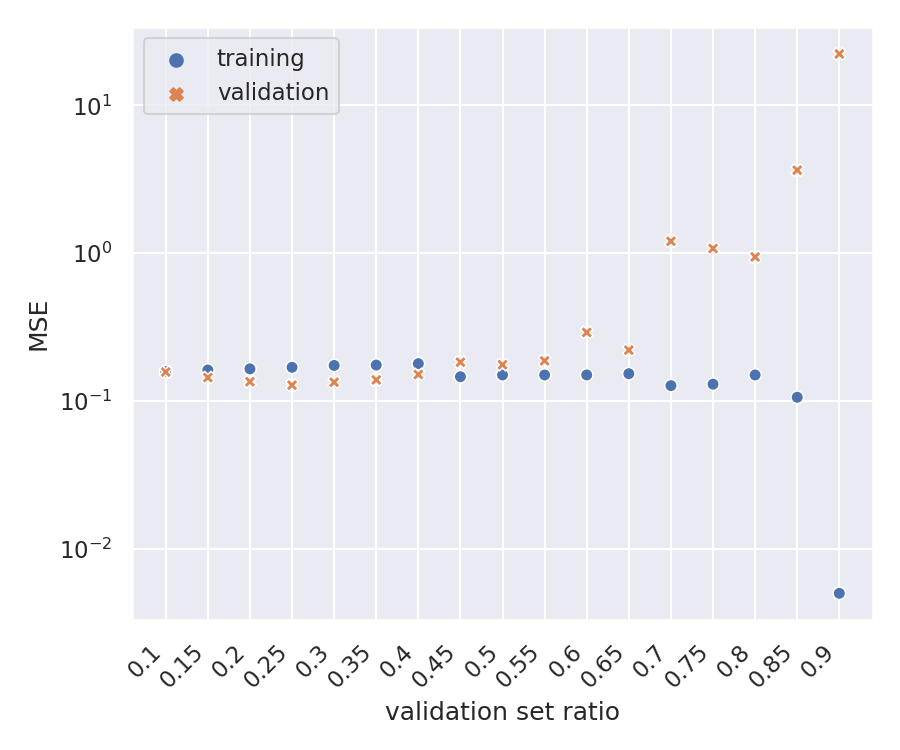

In [10]:
from IPython.display import Image
Image('./img/valsize_errors.png', width=480)

Given the results we choose to keep 10% of data into the test set, 10% into the validation set and the rest for training:

In [11]:
import sklearn
from sklearn.preprocessing import RobustScaler
import joblib

def rescale(df: pd.DataFrame,
            scl: sklearn.base.BaseEstimator,
            train: bool = False
           ) -> pd.DataFrame:
    '''
    Rescale the truncation levels only.
    
    Required arguments:
        df:    the dataframe,
        scl:   the scaler,
        train: whether df is training set.
        
    Returns:
        the scaler and the scaled dataframe.
    '''
    df_p1 = df[['weight', 'type']]
    df_p2 = df.filter(regex='^level_.*')
    
    if train:
        df_p2 = pd.DataFrame(scaler.fit_transform(df_p2), columns=df_p2.columns)
    else:
        df_p2 = pd.DataFrame(scaler.transform(df_p2), columns=df_p2.columns)
        
    # reset indices
    df_p1 = df_p1.reset_index(drop=True)
    df_p2 = df_p2.reset_index(drop=True)
        
    df = pd.concat([df_p1, df_p2], axis=1)
    
    return scaler, df

sol_train, sol_val = train_test_split(sol_train, test_size=0.1, shuffle=True, random_state=RAND)

# separate training and validation sets
df_val   = df_train.loc[df_train['solutions'].isin(sol_val)]
df_train = df_train.loc[df_train['solutions'].isin(sol_train)]

# save the labels to file
lab_train = df_train['exp']
lab_train.to_csv('./data/lab_train.csv', index=False)
lab_val = df_val['exp']
lab_val.to_csv('./data/lab_val.csv', index=False)
lab_test = df_test['exp']
lab_test.to_csv('./data/lab_test.csv', index=False)

# save the sets to file after scaling
scaler = RobustScaler()

# drop the columns and shuffle the content
df_train         = df_train.drop(columns=['solutions', 'init', 'exp'])
scaler, df_train = rescale(df_train, scaler, train=True)
#df_train         = df_train.sample(frac=1, random_state=RAND)
df_train.to_csv('./data/train.csv', index=False)

# save the trained scaler
joblib.dump(scaler, './models/scaler.pkl')

# do the same for validation and test sets
df_val    = df_val.drop(columns=['solutions', 'init', 'exp'])
_, df_val = rescale(df_val, scaler, train=False)
#df_val    = df_val.sample(frac=1, random_state=RAND)
df_val.to_csv('./data/val.csv', index=False)

df_test    = df_test.drop(columns=['solutions', 'init', 'exp'])
_, df_test = rescale(df_test, scaler, train=False)
#df_test    = df_test.sample(frac=1, random_state=RAND)
df_test.to_csv('./data/test.csv', index=False)

In [12]:
print('Training set effective size: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))
print('Training set effective size: {:.2f}%'.format(100 * df_val.shape[0] / df.shape[0]))
print('Training set effective size: {:.2f}%'.format(100 * df_test.shape[0] / df.shape[0]))

Training set effective size: 79.81%
Training set effective size: 9.33%
Training set effective size: 10.86%


Set useful constants:

In [13]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'
TEST = './data/test.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'
LAB_TEST   = './data/lab_test.csv'

## Linear Regression

We first analyse the effect of linear regression with $\ell_2$ regularisation. We define the estimator and then perform the optimisation:

In [14]:
from sklearn.linear_model import Ridge
import joblib

# choose the estimator
estimator = Ridge(random_state=RAND)

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/ridge.pkl']

We then define the hyperparameters for the optimisation:

In [15]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1.0e-2, 1.0e2, prior='log-uniform', name='alpha')]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/ridge_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [16]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

Ridge optimised in 34.711 seconds.
Ridge trained in 0.001 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [17]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,alpha,10.121278


The trained estimator is therefore:

In [18]:
import joblib

joblib.load(ESTIMATOR)

Ridge(alpha=10.121278284763648, random_state=123)

After training, we then compute the predictions and the metrics:

In [19]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

Ridge predicted in 0.003 seconds.
Ridge predicted in 0.001 seconds.
Ridge predicted in 0.001 seconds.


In [20]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ridge_train,554,0.175115,0.134222,0.216009,0.418468,0.305680,0.649508
ridge_val,48,0.107859,0.066872,0.148846,0.328419,0.268397,0.776258
ridge_test,59,0.160193,0.073488,0.246898,0.400242,0.292229,0.683566


Finally we produce all the necessary plots and display them:

In [21]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

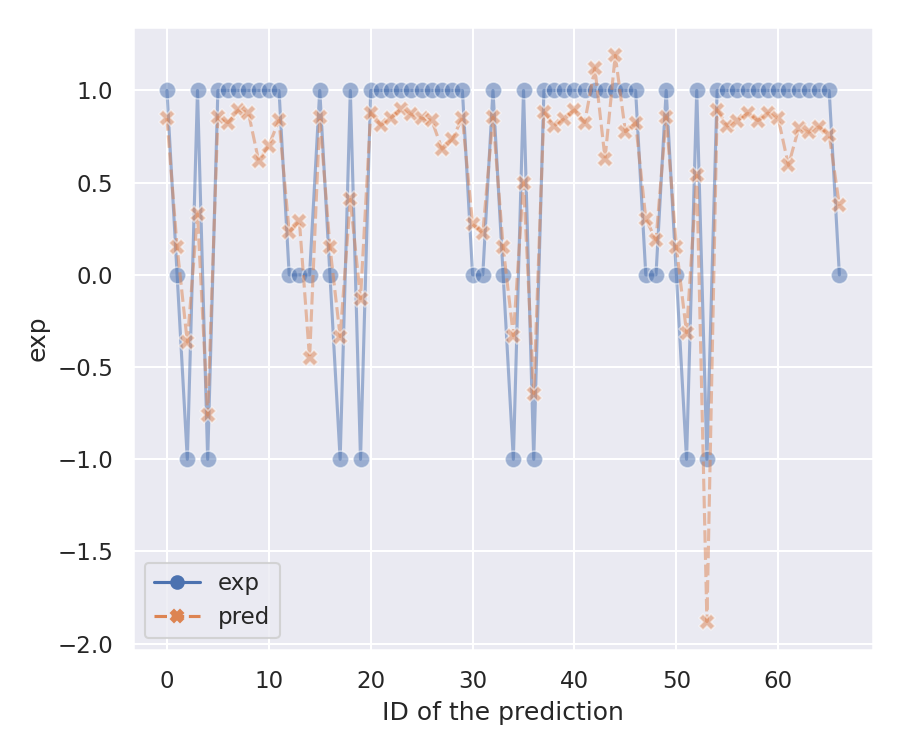

In [22]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

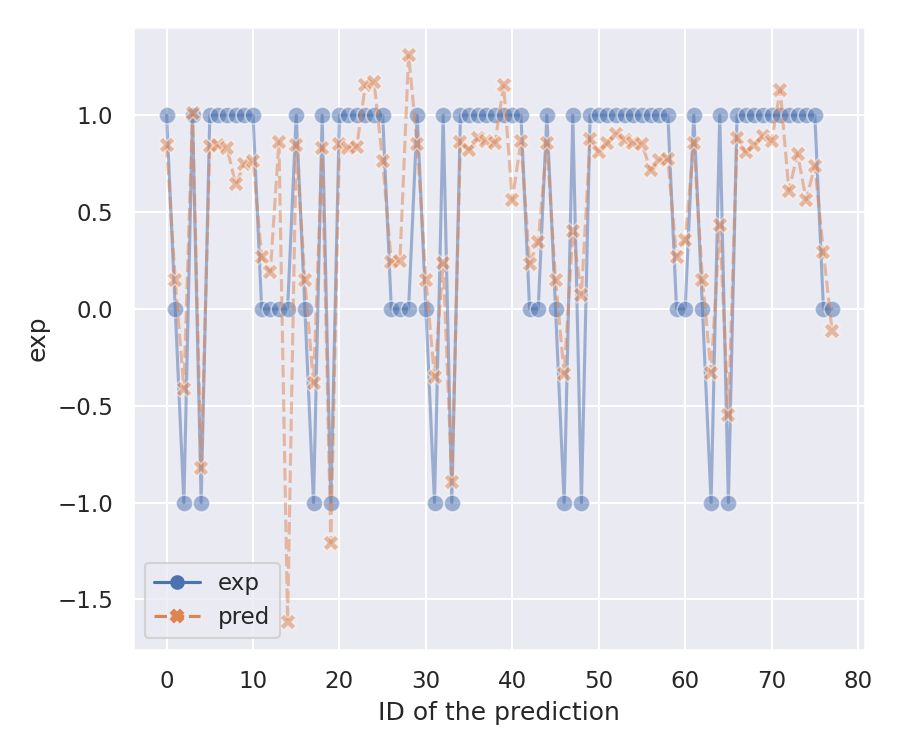

In [23]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

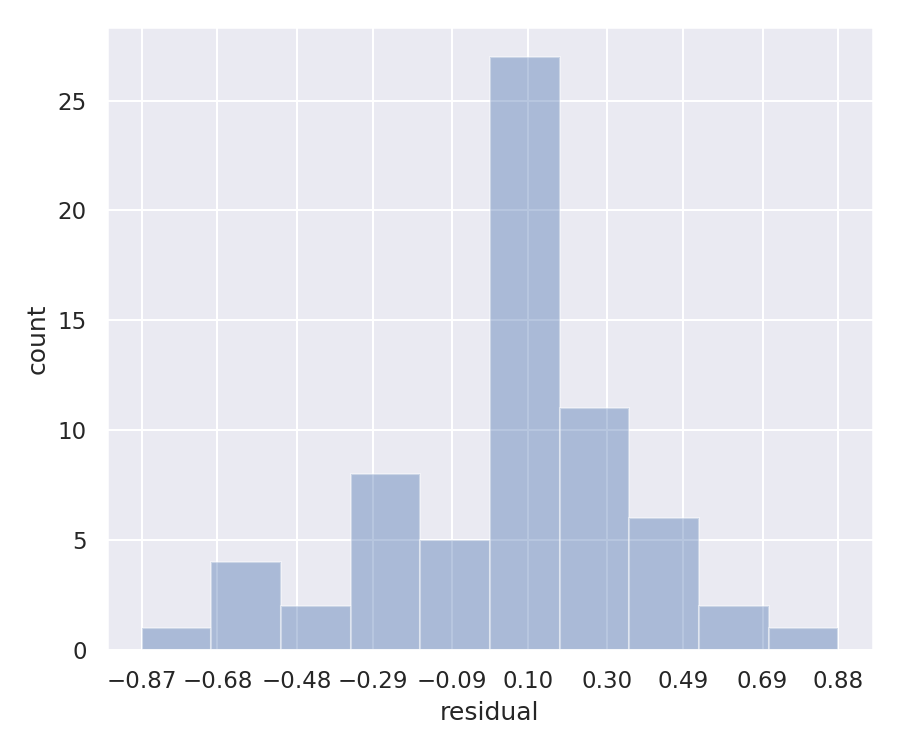

In [24]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

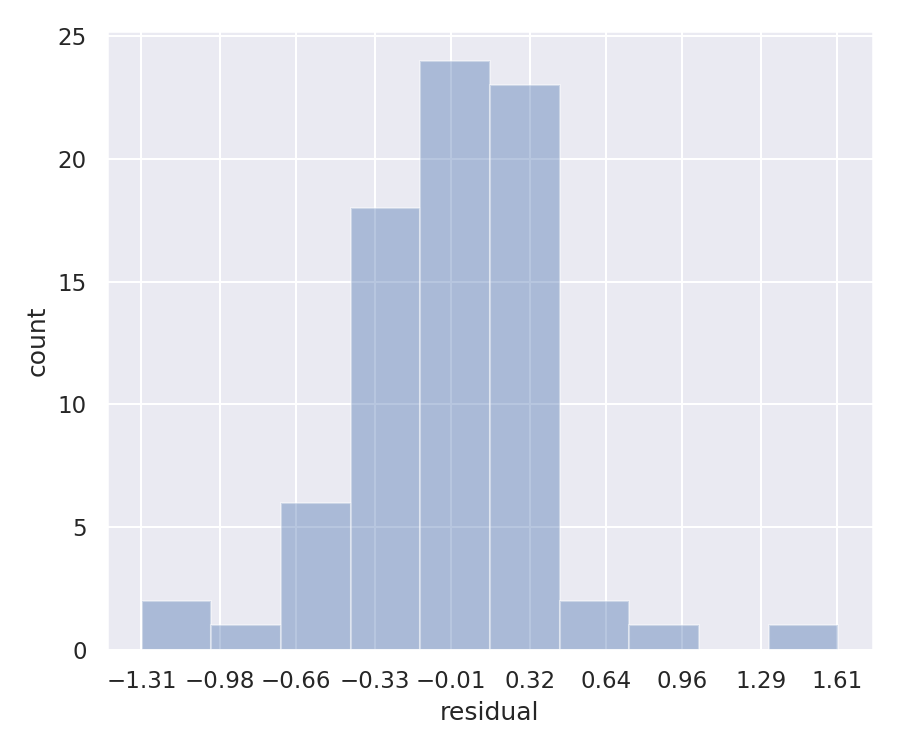

In [25]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

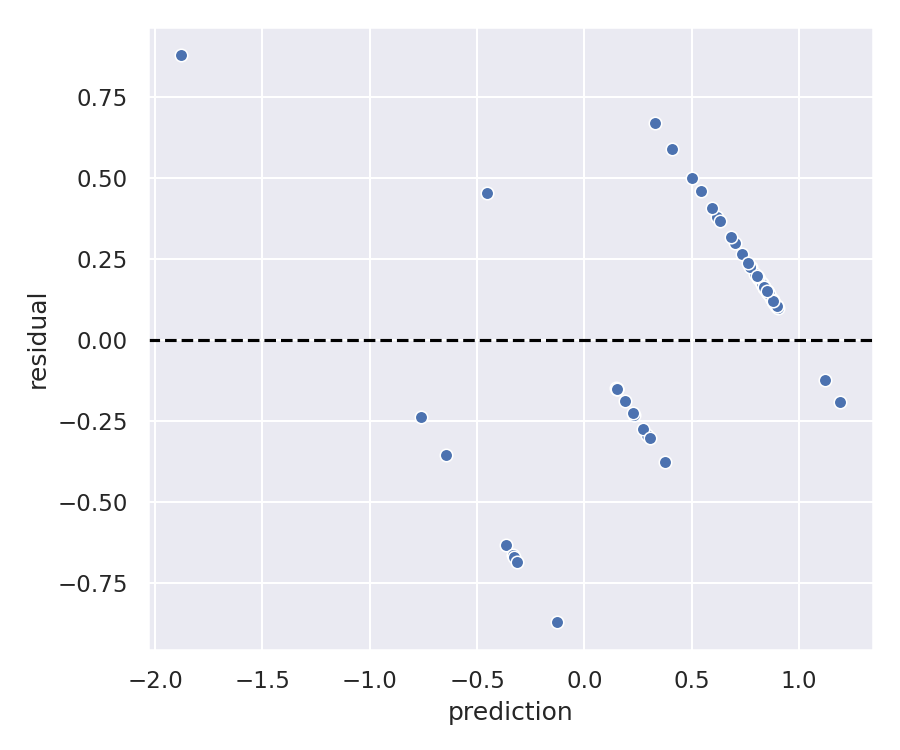

In [26]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

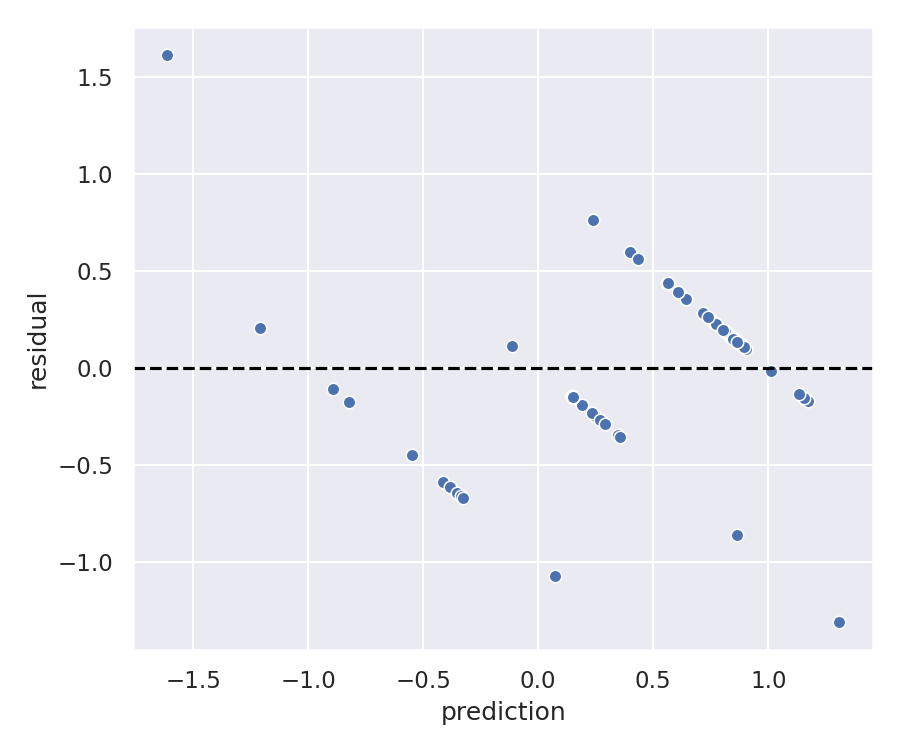

In [27]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [28]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.001 seconds.
Trained ratio 0.20 in 0.001 seconds.
Trained ratio 0.30 in 0.001 seconds.
Trained ratio 0.40 in 0.001 seconds.
Trained ratio 0.50 in 0.002 seconds.
Trained ratio 0.60 in 0.001 seconds.
Trained ratio 0.70 in 0.001 seconds.
Trained ratio 0.80 in 0.001 seconds.
Trained ratio 0.90 in 0.001 seconds.
Learning curve for Ridge trained in 0.093 seconds.


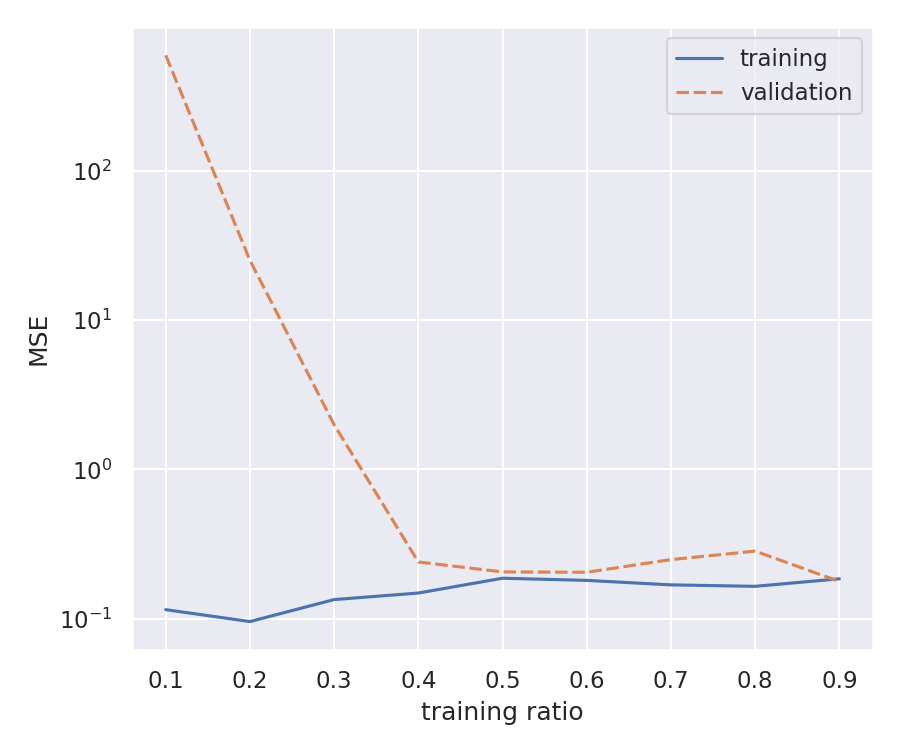

In [29]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Linear SVM

We remain in the family of linear models but we start considering the support vector machine (SVM) version (w/o _kernel trick_).

In [30]:
from sklearn.svm import LinearSVR
import joblib

# choose the estimator
estimator = LinearSVR(random_state=RAND, max_iter=1e6)

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/linearsvr.pkl']

We then define the hyperparameters for the optimisation:

In [31]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1.0e-4, 1.0e-1, prior='log-uniform', name='epsilon'),
          Real(1.0e-1, 1.0e3, prior='log-uniform', name='C'),
          Categorical(['epsilon_insensitive',
                       'squared_epsilon_insensitive'
                      ],
                      name='loss'
                     )
         ]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/linearsvr_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [32]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/sit

After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [33]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,epsilon,0.1
1,C,0.5586093876080802
2,loss,squared_epsilon_insensitive


The trained estimator is therefore:

In [34]:
import joblib

joblib.load(ESTIMATOR)

LinearSVR(C=0.5586093876080802, epsilon=0.1, loss='squared_epsilon_insensitive',
          max_iter=1000000.0, random_state=123)

After training, we then compute the predictions and the metrics:

In [35]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LinearSVR predicted in 0.009 seconds.
LinearSVR predicted in 0.001 seconds.
LinearSVR predicted in 0.001 seconds.


In [36]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
linearsvr_train,554,2.474753,1.238591,3.710915,1.573135,0.476619,-3.953202
linearsvr_val,48,1.391596,-0.489780,3.272972,1.179659,0.388046,-1.886726
linearsvr_test,59,2.416208,-0.248586,5.081002,1.554416,0.487445,-3.772795


Finally we produce all the necessary plots and display them:

In [37]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

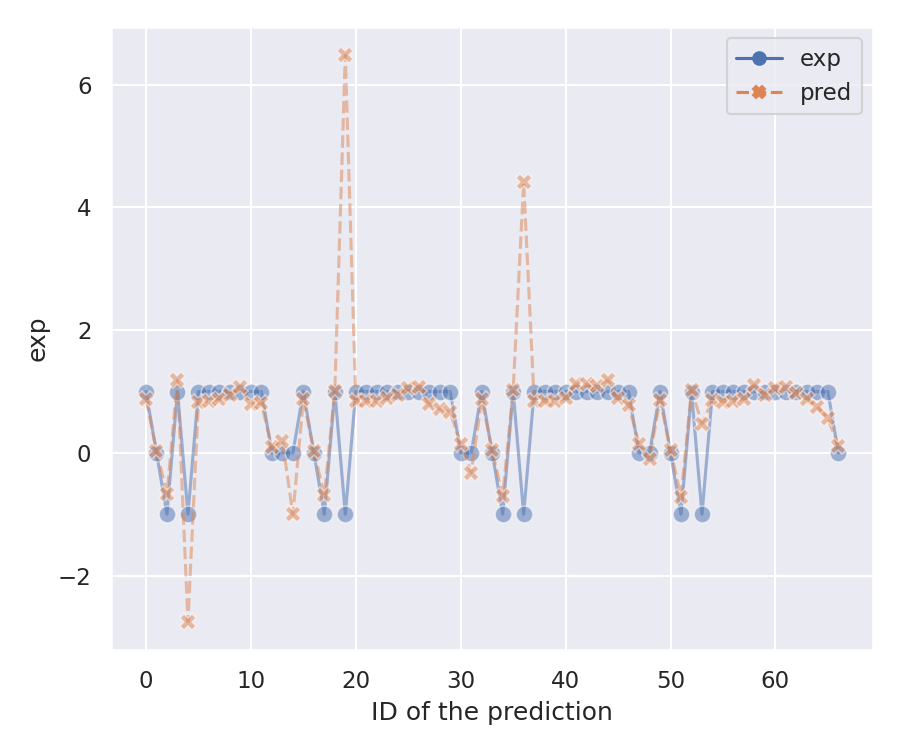

In [38]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

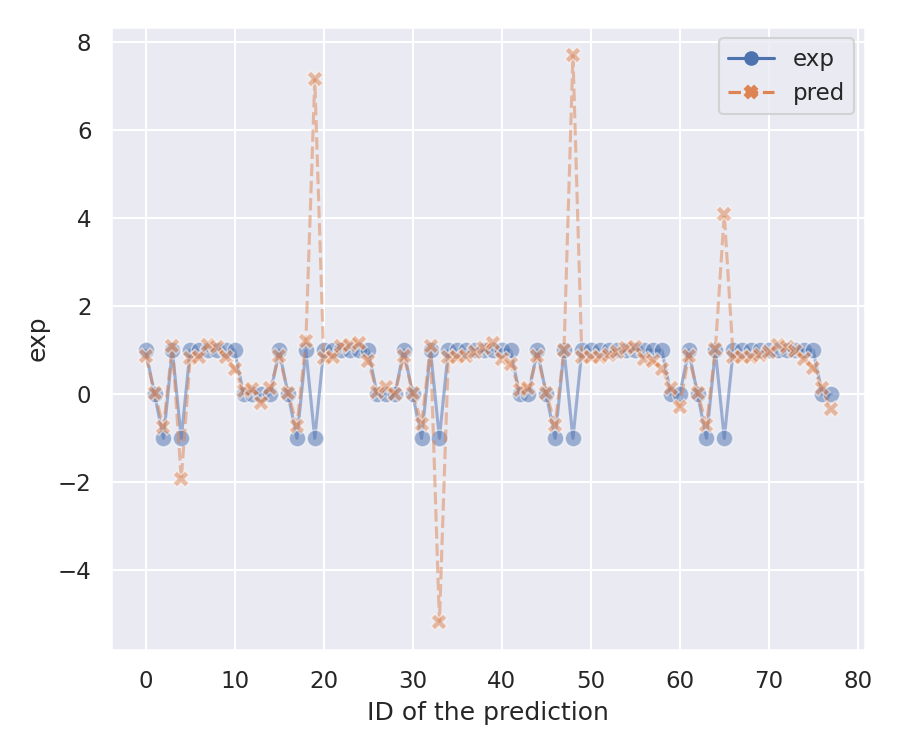

In [39]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

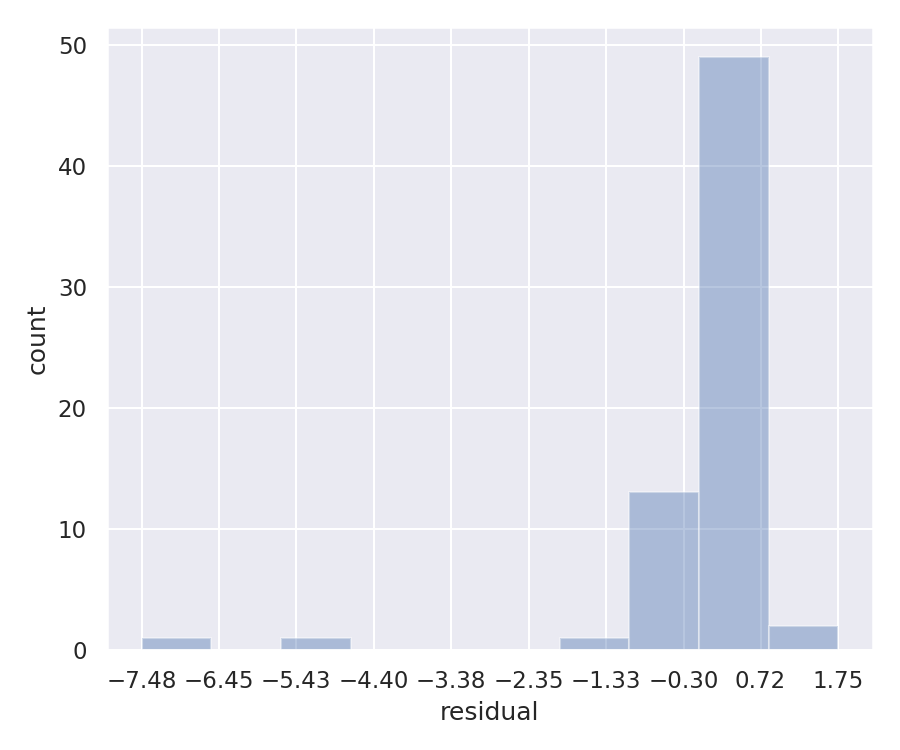

In [40]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

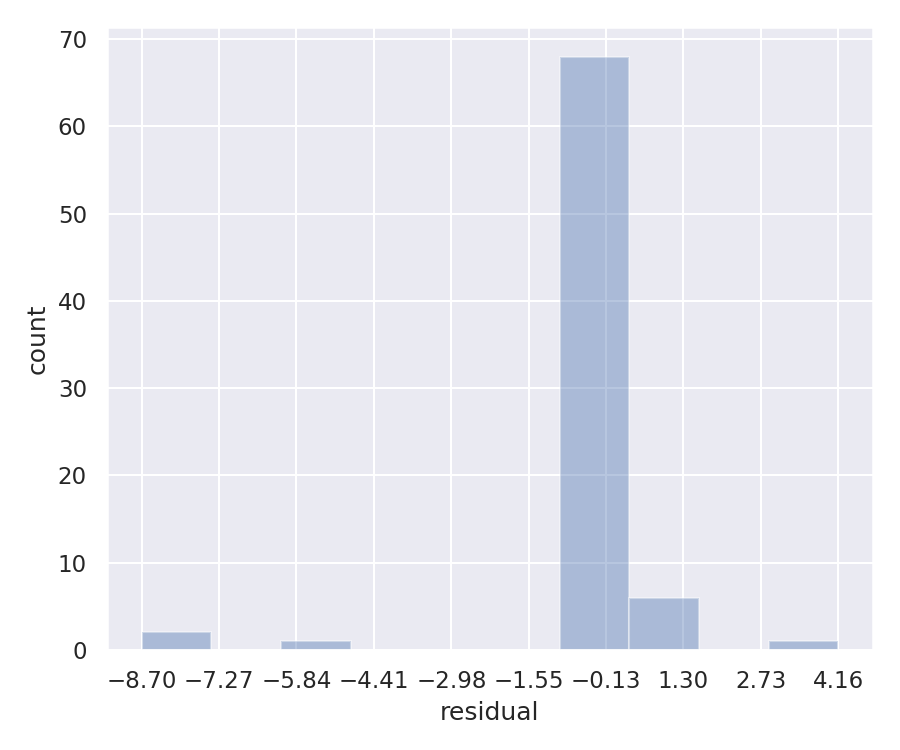

In [41]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

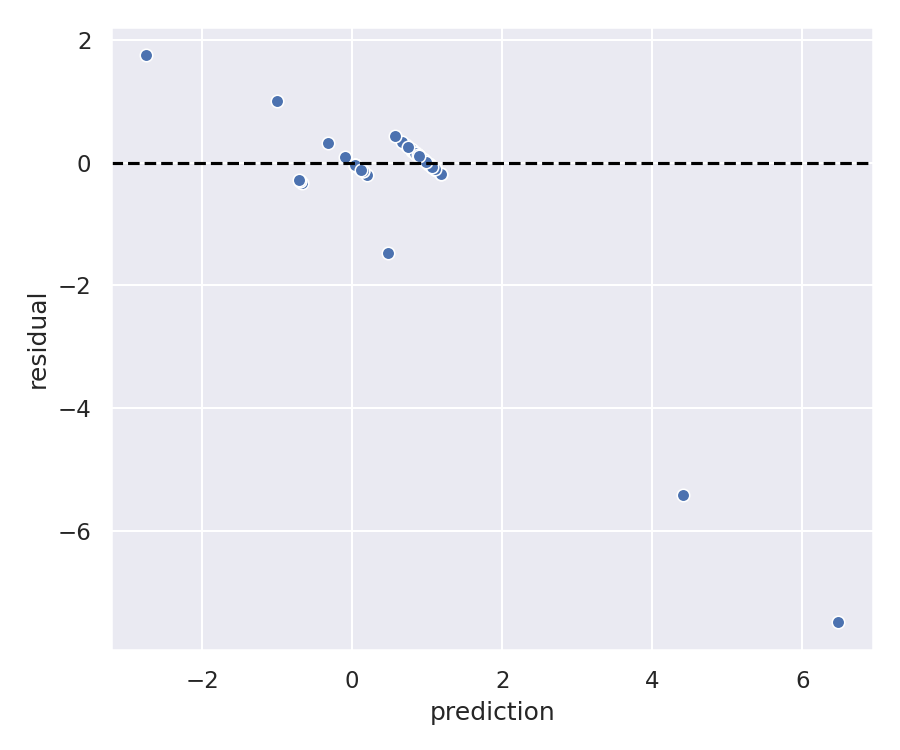

In [42]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

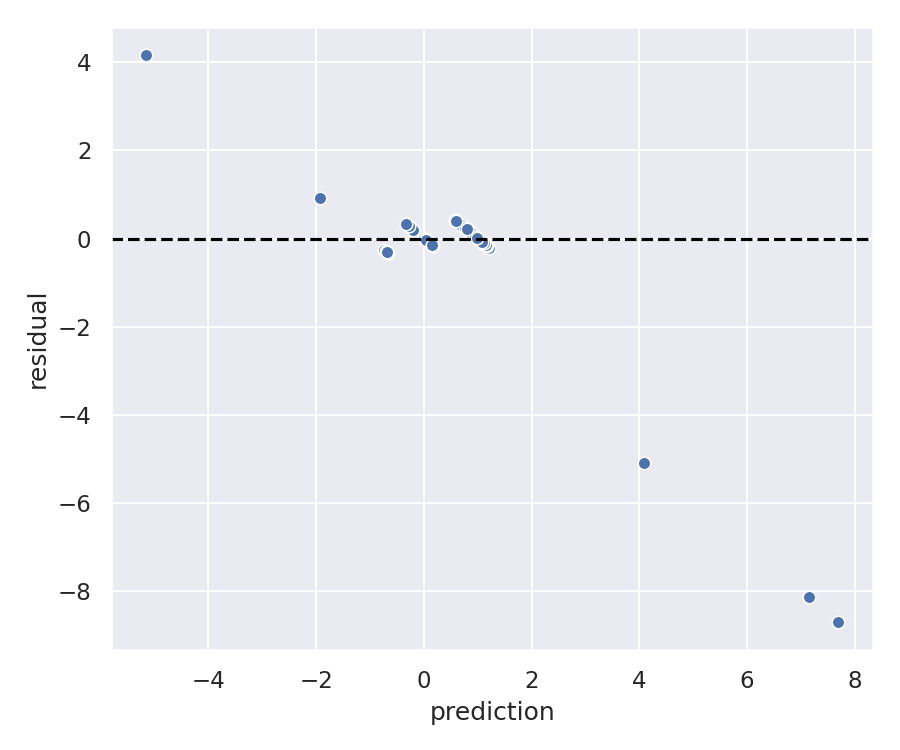

In [43]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [44]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.10 in 2.488 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.20 in 5.569 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.30 in 8.200 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

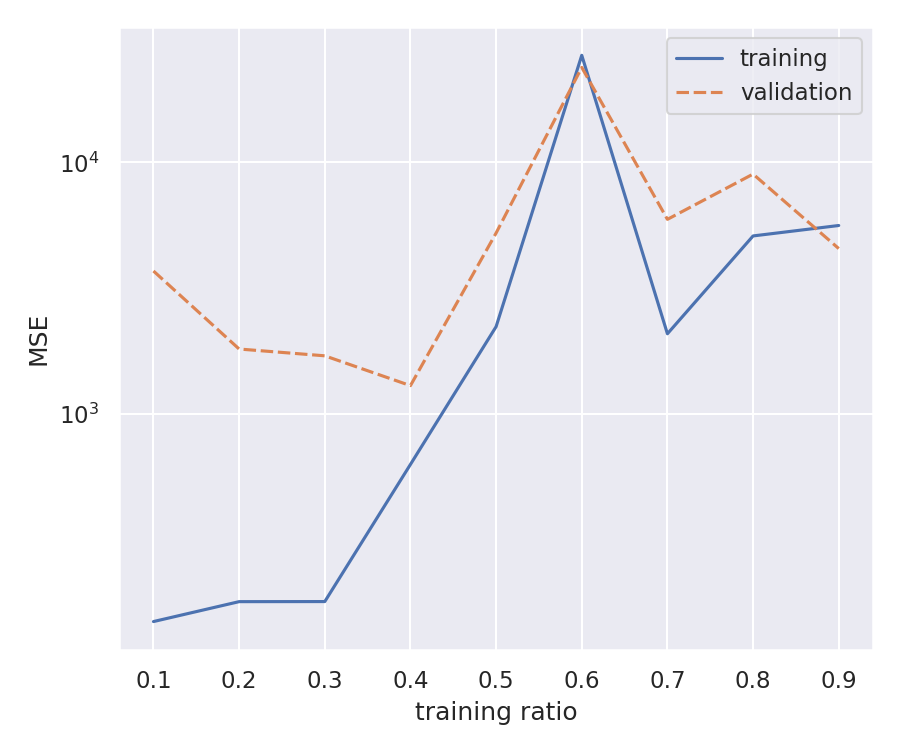

In [45]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Gaussian SVM

We then change completely algorithms and use the _kernel trick_ (w/ Gaussian kernel) to compute the predictions.

In [46]:
from sklearn.svm import SVR
import joblib

# choose the estimator
estimator = SVR(kernel='rbf')

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/svr.pkl']

We then define the hyperparameters for the optimisation:

In [47]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1e-5, 1e1, prior='log-uniform', name='gamma'),
          Real(1.0e-3, 1.0e1, prior='log-uniform', name='epsilon'),
          Real(1.0e1, 1.0e4, prior='log-uniform', name='C')
         ]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/svr_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [48]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

SVR optimised in 44.526 seconds.
SVR trained in 0.074 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [49]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,gamma,0.000010
1,epsilon,0.056142
2,C,10000.000000


The trained estimator is therefore:

In [50]:
import joblib

joblib.load(ESTIMATOR)

SVR(C=10000.0, epsilon=0.056141979944302235, gamma=1e-05)

After training, we then compute the predictions and the metrics:

In [51]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

SVR predicted in 0.003 seconds.
SVR predicted in 0.001 seconds.
SVR predicted in 0.001 seconds.


In [52]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
svr_train,554,0.045262,0.021045,0.069479,0.212749,0.080388,0.909408
svr_val,48,0.012971,-0.001357,0.027298,0.113889,0.062276,0.973094
svr_test,59,0.025569,0.005093,0.046045,0.159904,0.080698,0.949492


Finally we produce all the necessary plots and display them:

In [53]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

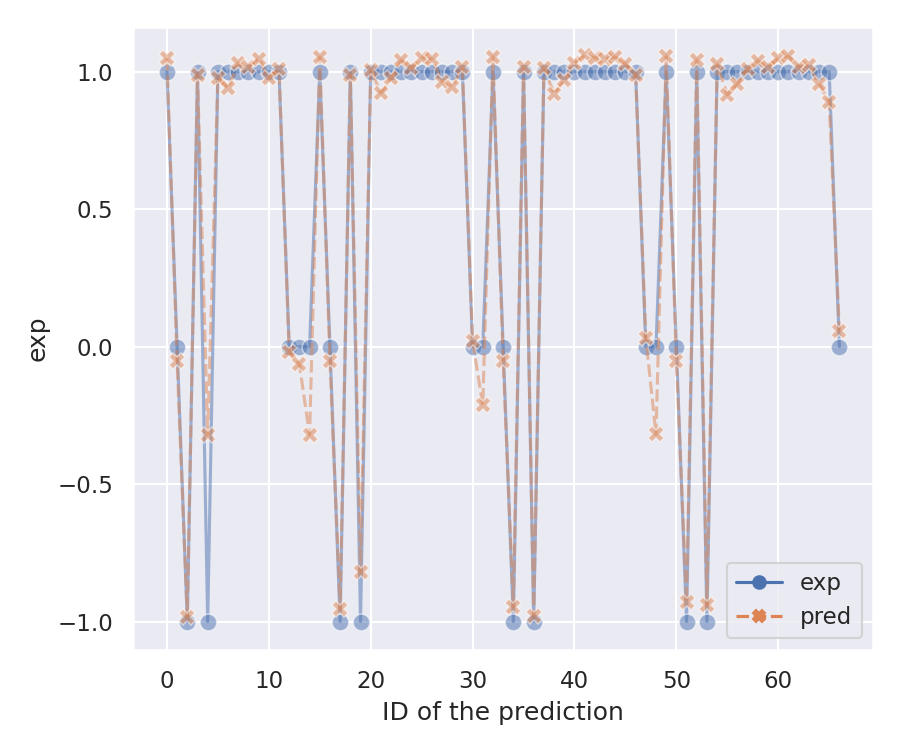

In [54]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

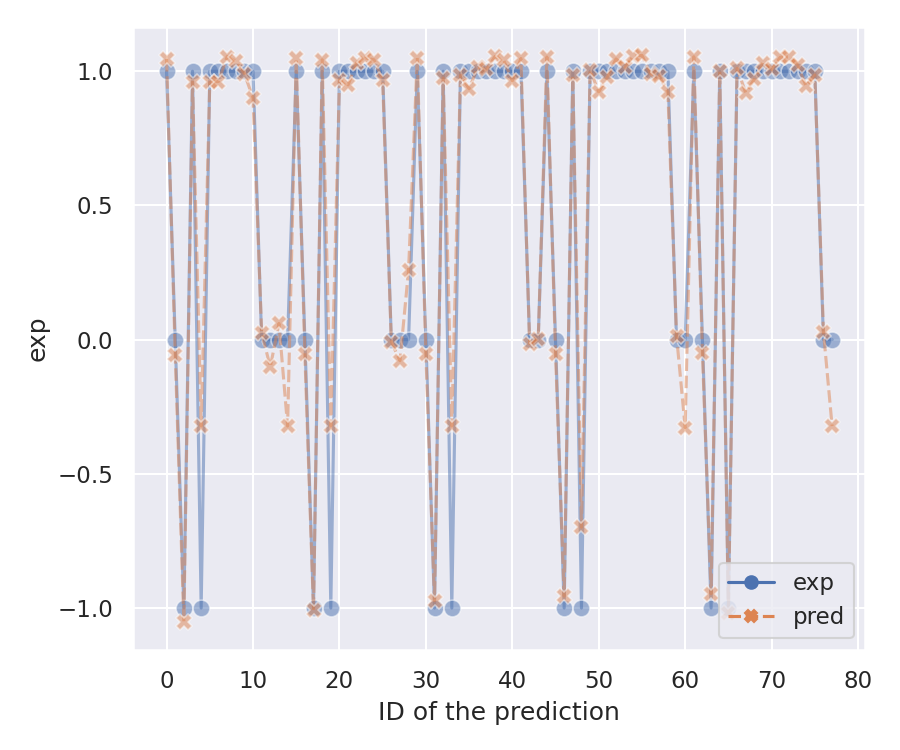

In [55]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

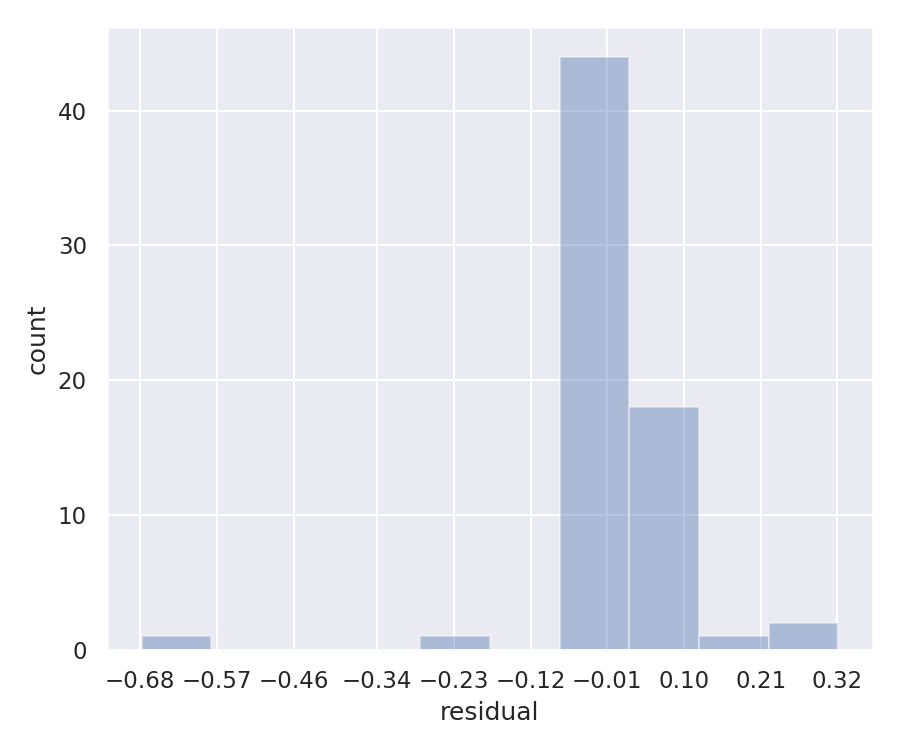

In [56]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

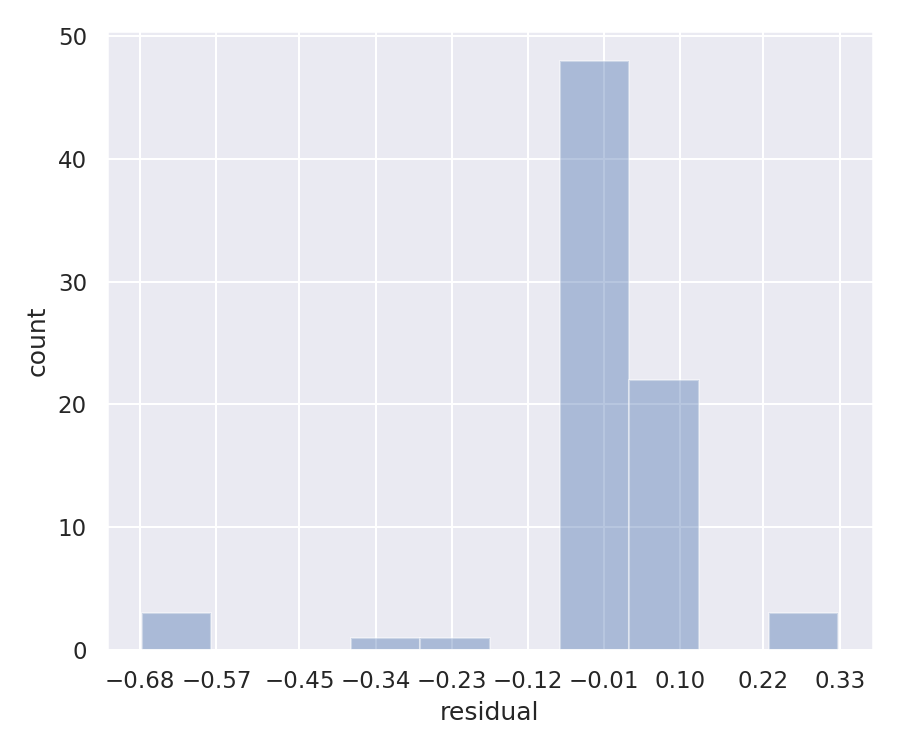

In [57]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

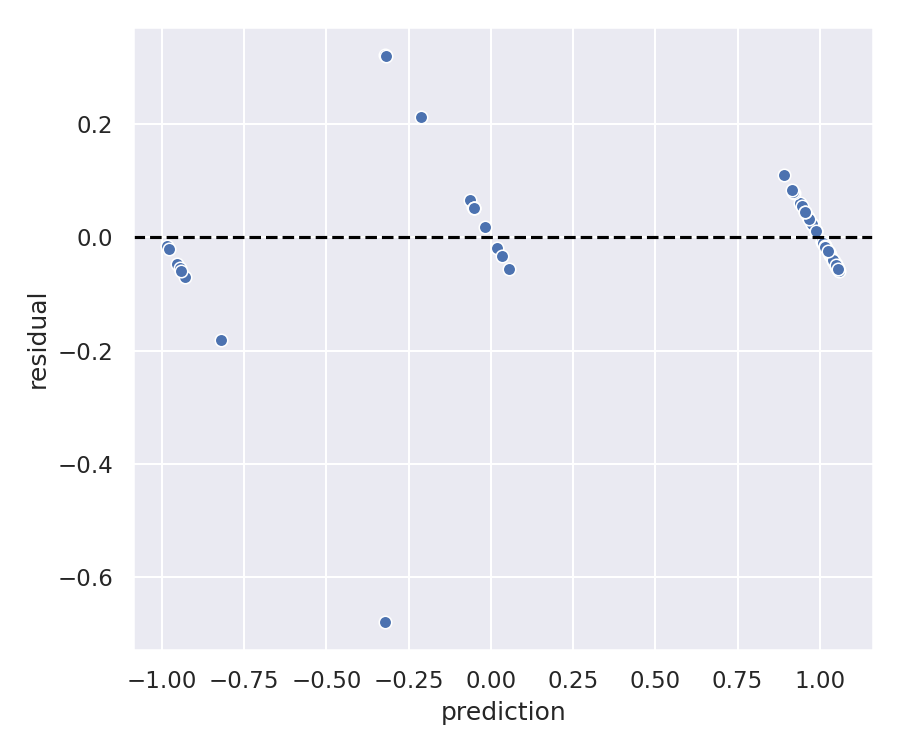

In [58]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

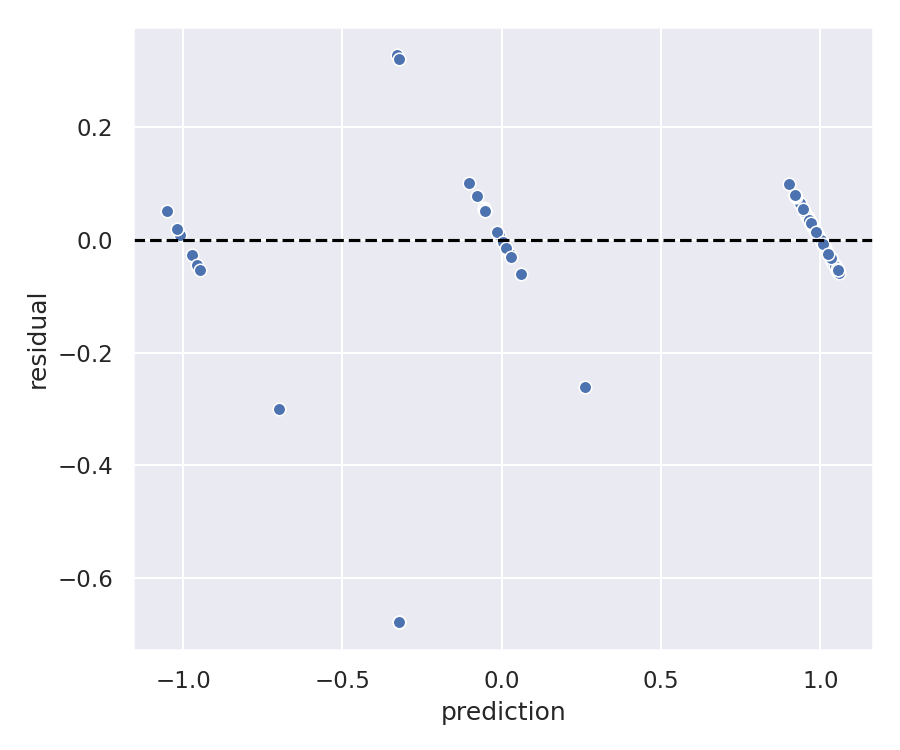

In [59]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [60]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.003 seconds.
Trained ratio 0.20 in 0.005 seconds.
Trained ratio 0.30 in 0.010 seconds.
Trained ratio 0.40 in 0.028 seconds.
Trained ratio 0.50 in 0.071 seconds.
Trained ratio 0.60 in 0.104 seconds.
Trained ratio 0.70 in 0.094 seconds.
Trained ratio 0.80 in 0.096 seconds.
Trained ratio 0.90 in 0.104 seconds.
Learning curve for SVR trained in 0.589 seconds.


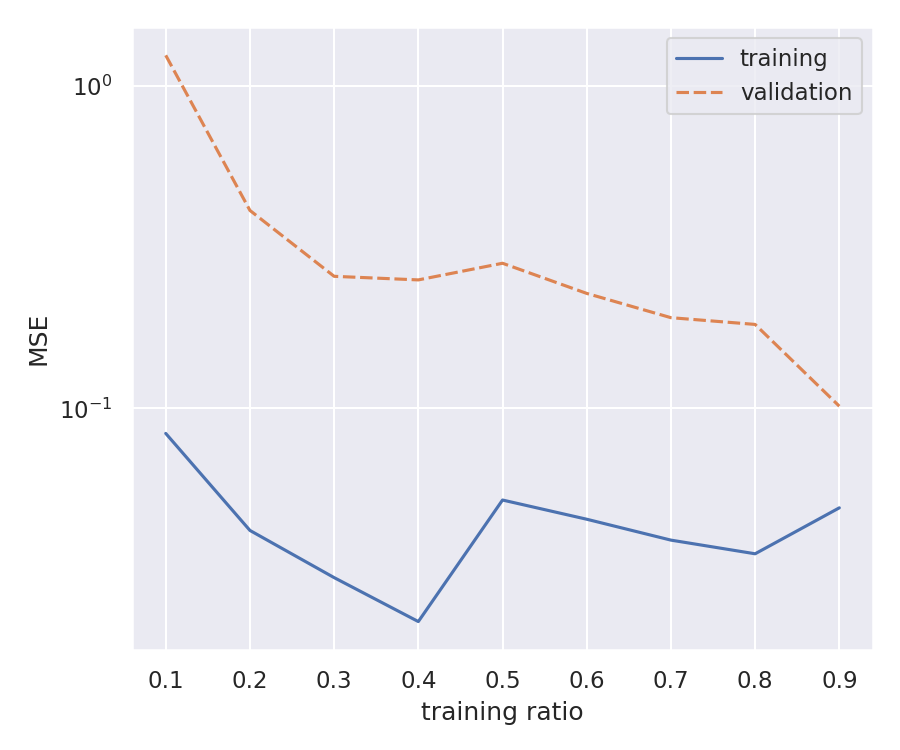

In [61]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Random Forests

We then move to the decision trees and in particular to the ensemble learning technique of _random forests_.

In [62]:
from lightgbm import LGBMRegressor
import joblib

# choose the estimator
estimator = LGBMRegressor(boosting_type = 'rf',
                          objective = 'regression',
                          subsample_freq = 1,
                          n_jobs = -1,
                          importance_type='gain'
                         )

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/rf_{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/rf_lgbmregressor.pkl']

We then define the hyperparameters for the optimisation:

In [63]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Integer(2, 200, name='num_leaves'),
          Integer(50, 500, name='max_depth'),
          Integer(2, 50, name='n_estimators'),
          Real(0.1, 0.99, name='subsample'),
          Real(0.7, 1.0, name='colsample_bytree'),
          Real(1.0e-6, 1.0e-2,
               prior='log-uniform',
               name='min_child_weight'
              ),
          Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_alpha'),
          Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_lambda')
         ]

# save the parameters
PARAMS = './models/rf_{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/rf_lgbmregressor_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [64]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

LGBMRegressor optimised in 54.571 seconds.
LGBMRegressor trained in 0.783 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [65]:
import pandas as pd

!mv ./hypers/lgbmregressor.csv ./hypers/rndfor.csv
pd.read_csv('./hypers/rndfor.csv'.format(name))

,names,values
0,num_leaves,70.000000
1,max_depth,500.000000
2,n_estimators,50.000000
3,subsample,0.990000
4,colsample_bytree,1.000000
5,min_child_weight,0.000001
6,reg_alpha,0.100000
7,reg_lambda,0.123078


The trained estimator is therefore:

In [66]:
import joblib

joblib.load(ESTIMATOR)

LGBMRegressor(boosting_type='rf', importance_type='gain', max_depth=500,
              min_child_weight=1e-06, n_estimators=50, num_leaves=70,
              objective='regression', reg_alpha=0.1,
              reg_lambda=0.12307761203933984, subsample=0.99, subsample_freq=1)

After training, we then compute the predictions and the metrics:

In [67]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.003 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [68]:
import json

!mv ./metrics/lgbmregressor_train.json ./metrics/rf_lgbmregressor_train.json
with open('./metrics/rf_{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
!mv ./metrics/lgbmregressor_val.json ./metrics/rf_lgbmregressor_val.json
with open('./metrics/rf_{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
!mv ./metrics/lgbmregressor_test.json ./metrics/rf_lgbmregressor_test.json    
with open('./metrics/rf_{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lgbmregressor_train,554,0.023632,0.012571,0.034694,0.153728,0.042902,0.952700
lgbmregressor_val,48,0.003536,-0.000040,0.007112,0.059466,0.024297,0.992664
lgbmregressor_test,59,0.011051,-0.002755,0.024857,0.105124,0.036618,0.978171


Finally we produce all the necessary plots and display them:

In [69]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'rf_' + name + '_val'
OUTPUT_TEST = 'rf_' + name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

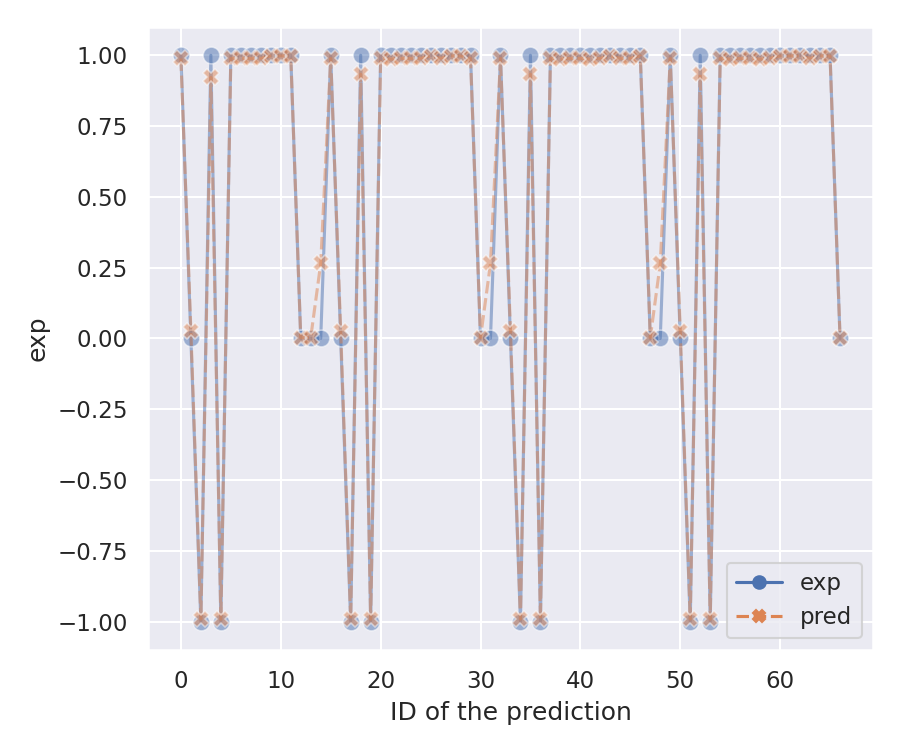

In [70]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

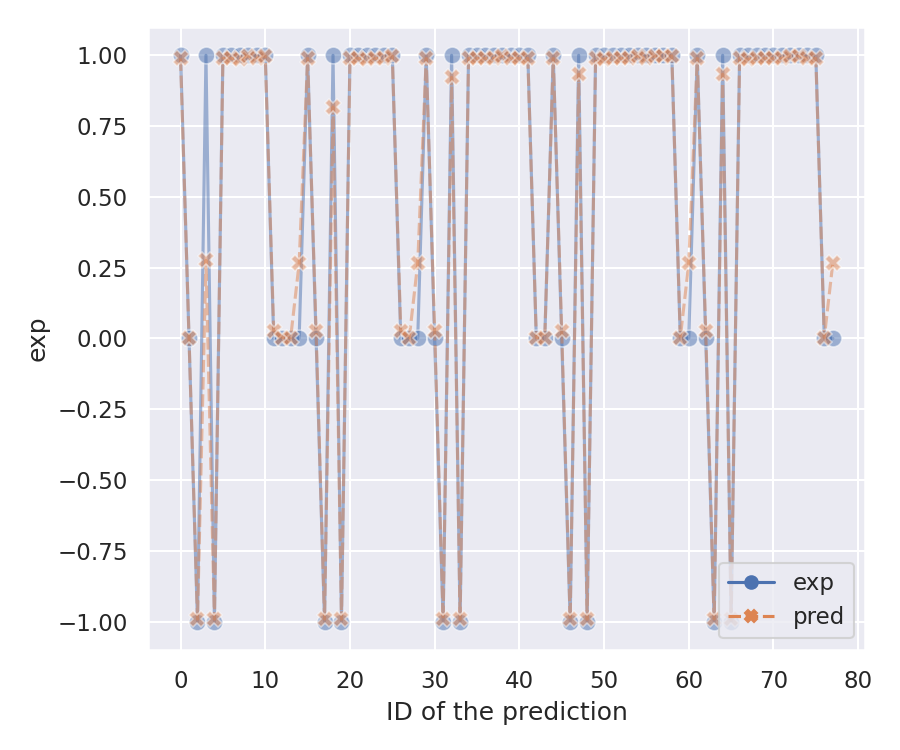

In [71]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

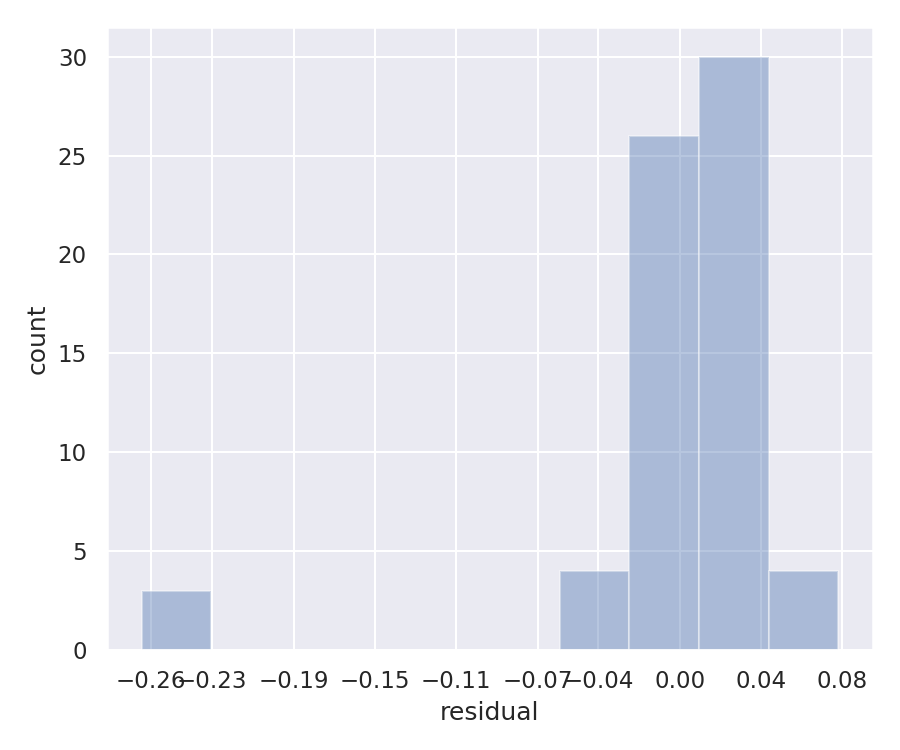

In [72]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

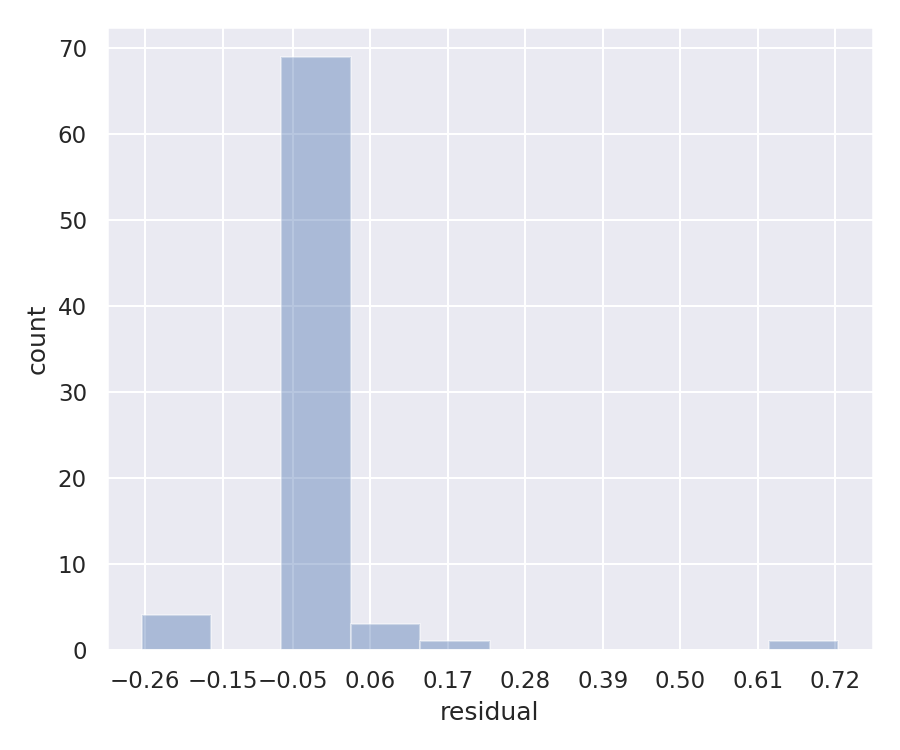

In [73]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

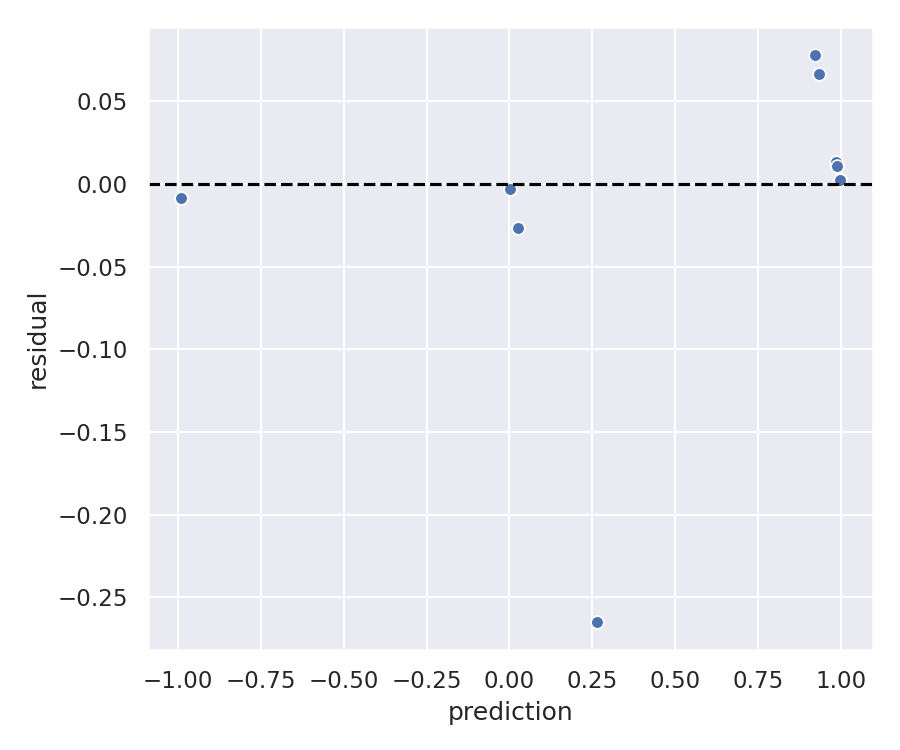

In [74]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

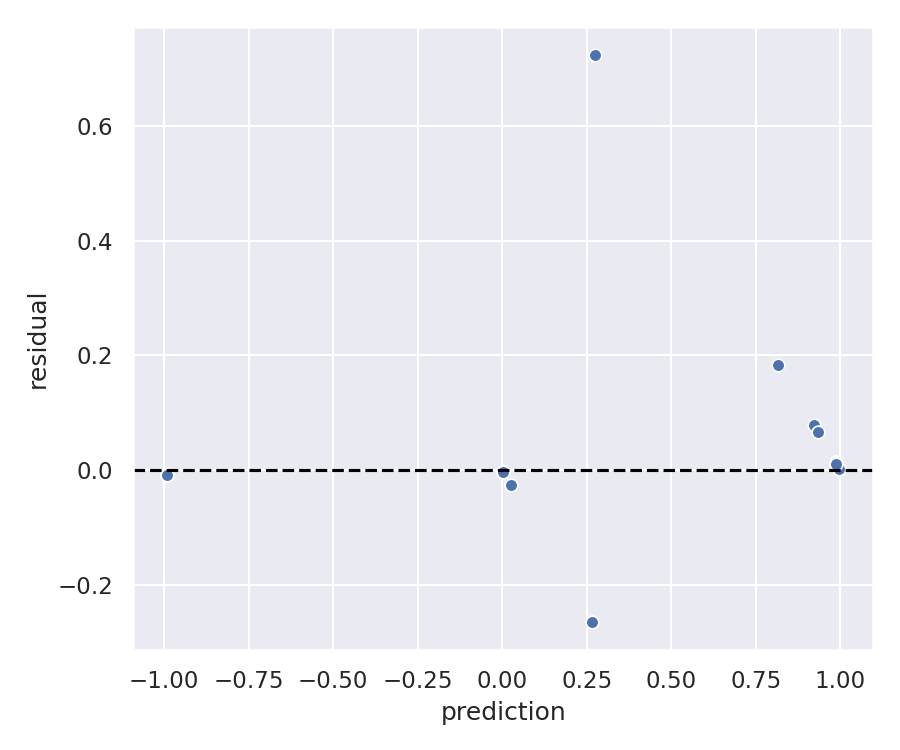

In [75]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [76]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'rf_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.012 seconds.
Trained ratio 0.20 in 0.011 seconds.
Trained ratio 0.30 in 0.014 seconds.
Trained ratio 0.40 in 0.019 seconds.
Trained ratio 0.50 in 0.021 seconds.
Trained ratio 0.60 in 0.025 seconds.
Trained ratio 0.70 in 0.025 seconds.
Trained ratio 0.80 in 0.027 seconds.
Trained ratio 0.90 in 0.030 seconds.
Learning curve for LGBMRegressor trained in 0.225 seconds.


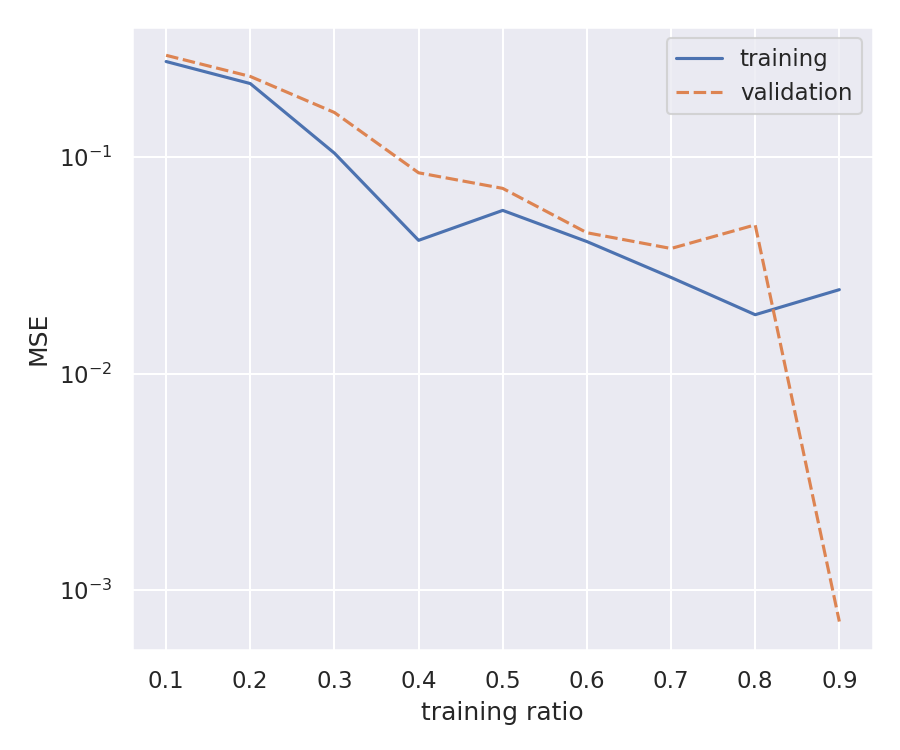

In [77]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Gradient Boosting

We consider another ensemble technique based on decision trees: gradient boosting.

In [78]:
from lightgbm import LGBMRegressor
import joblib

# choose the estimator
estimator = LGBMRegressor(boosting_type = 'gbdt',
                          objective = 'regression',
                          subsample_freq = 1,
                          n_jobs = 1,
                          importance_type='gain'
                         )

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/gbdt_{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/gbdt_lgbmregressor.pkl']

We then define the hyperparameters for the optimisation:

In [79]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Integer(2, 25, name='num_leaves'),
          Integer(2, 25, name='max_depth'),
          Real(1e-3, 1e-1, prior='log-uniform', name='learning_rate'),
          Integer(1e2, 1e4, prior='log-uniform', name='n_estimators'),
          Real(0.1, 0.99, name='subsample'),
          Real(0.7, 1.0, name='colsample_bytree'),
          Real(1.0e-3, 1.0e-1, prior='log-uniform', name='min_child_weight'),
          Real(1.0e0, 1.0e2, prior='log-uniform', name='reg_alpha'),
          Real(1.0e0, 1.0e3, prior='log-uniform', name='reg_lambda')
         ]
# save the parameters
PARAMS = './models/gbdt_{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/gbdt_lgbmregressor_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [80]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

LGBMRegressor optimised in 123.550 seconds.
LGBMRegressor trained in 0.165 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [81]:
import pandas as pd

!mv ./hypers/lgbmregressor.csv ./hypers/grdbst.csv
pd.read_csv('./hypers/grdbst.csv'.format(name))

,names,values
0,num_leaves,10.000000
1,max_depth,25.000000
2,learning_rate,0.100000
3,n_estimators,1589.000000
4,subsample,0.662908
5,colsample_bytree,1.000000
6,min_child_weight,0.001000
7,reg_alpha,1.000000
8,reg_lambda,1.000000


The trained estimator is therefore:

In [82]:
import joblib

joblib.load(ESTIMATOR)

LGBMRegressor(importance_type='gain', max_depth=25, n_estimators=1589, n_jobs=1,
              num_leaves=10, objective='regression', reg_alpha=1.0,
              reg_lambda=1.0, subsample=0.6629078673157304, subsample_freq=1)

After training, we then compute the predictions and the metrics:

In [83]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [84]:
import json

!mv ./metrics/lgbmregressor_train.json ./metrics/gbdt_lgbmregressor_train.json
with open('./metrics/gbdt_{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
!mv ./metrics/lgbmregressor_val.json ./metrics/gbdt_lgbmregressor_val.json    
with open('./metrics/gbdt_{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
!mv ./metrics/lgbmregressor_test.json ./metrics/gbdt_lgbmregressor_test.json    
with open('./metrics/gbdt_{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lgbmregressor_train,554,0.005652,0.002285,0.009020,0.075183,0.024088,0.988687
lgbmregressor_val,48,0.000164,0.000089,0.000239,0.012814,0.008765,0.999659
lgbmregressor_test,59,0.000853,-0.000145,0.001852,0.029211,0.015899,0.998315


Finally we produce all the necessary plots and display them:

In [85]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'gbdt_' + name + '_val'
OUTPUT_TEST = 'gbdt_' + name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

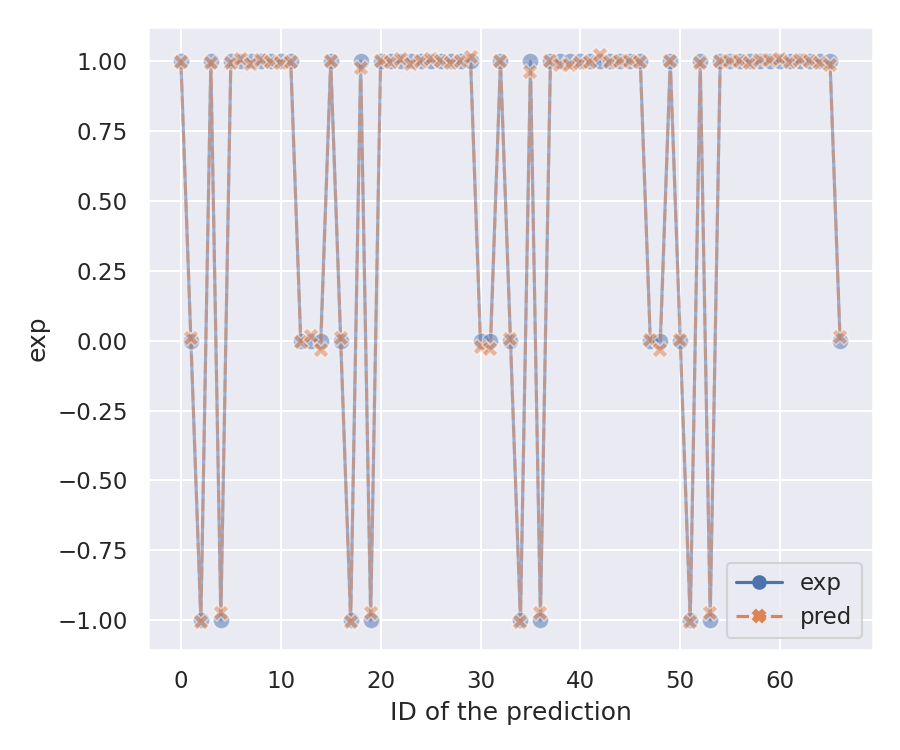

In [86]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

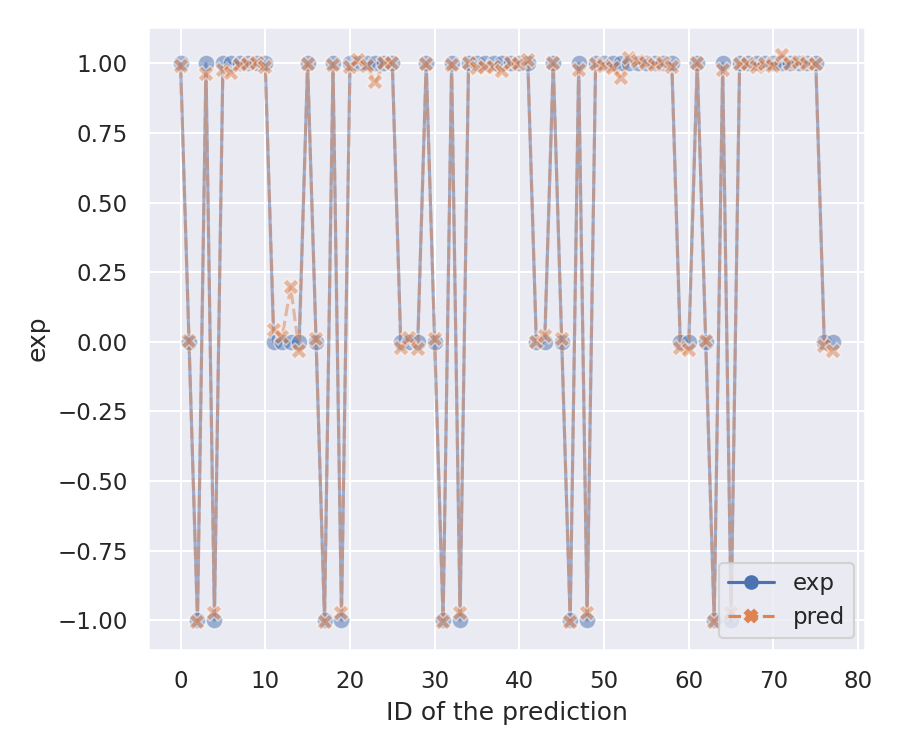

In [87]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

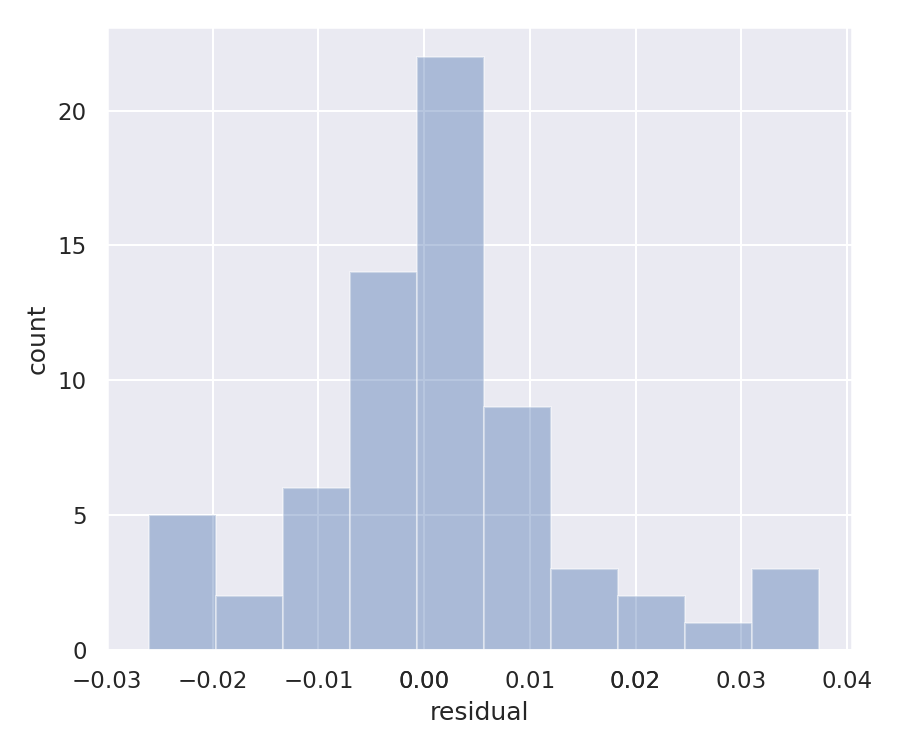

In [88]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

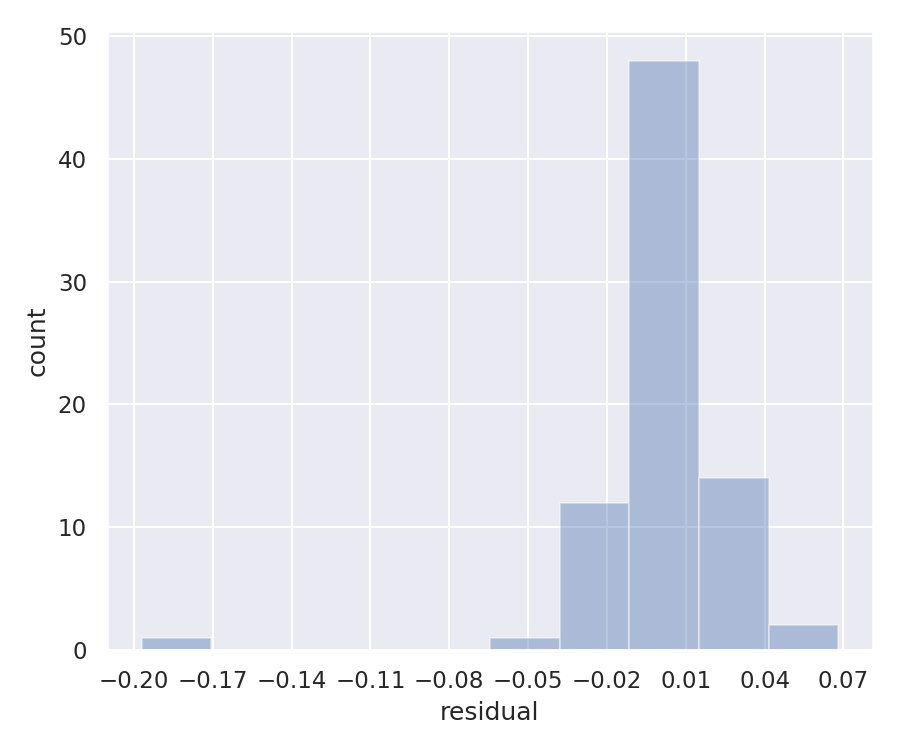

In [89]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

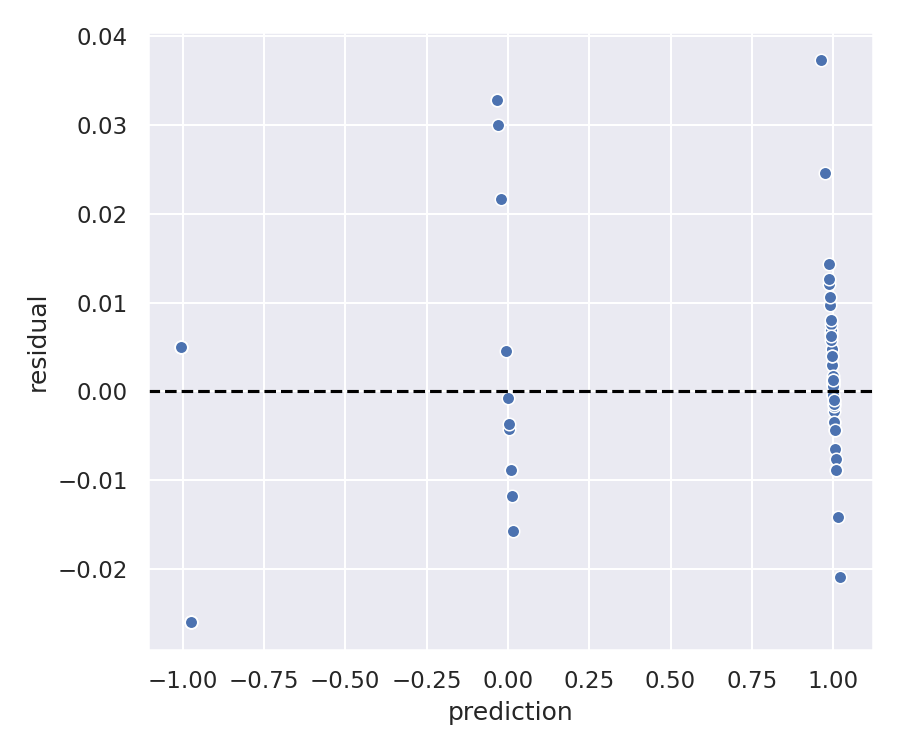

In [90]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

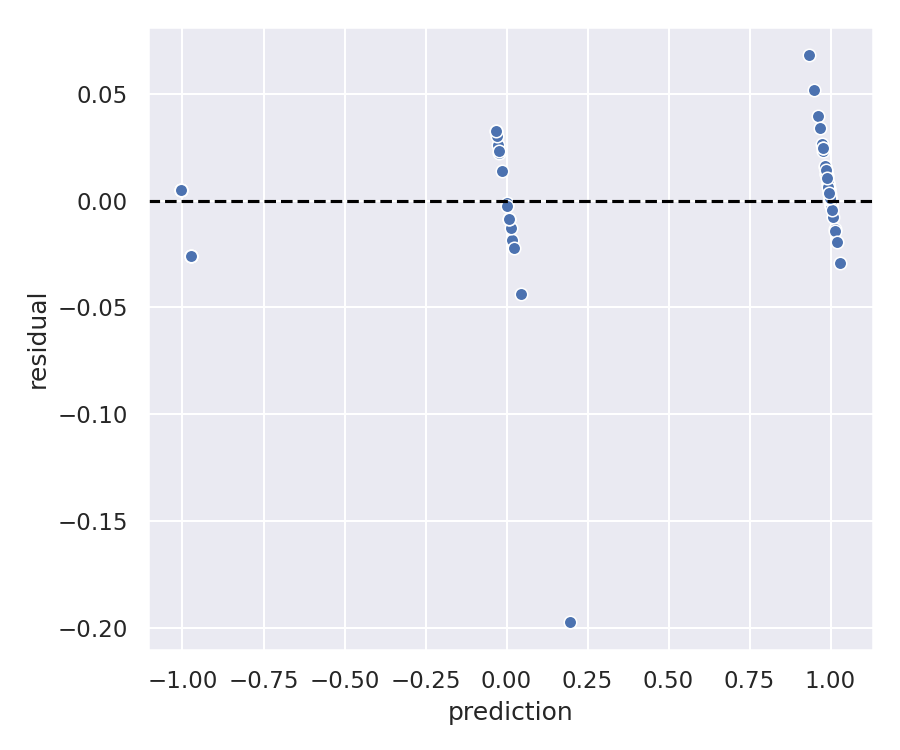

In [91]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [92]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'gbdt_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.026 seconds.
Trained ratio 0.20 in 0.045 seconds.
Trained ratio 0.30 in 0.064 seconds.
Trained ratio 0.40 in 0.078 seconds.
Trained ratio 0.50 in 0.114 seconds.
Trained ratio 0.60 in 0.127 seconds.
Trained ratio 0.70 in 0.139 seconds.
Trained ratio 0.80 in 0.148 seconds.
Trained ratio 0.90 in 0.191 seconds.
Learning curve for LGBMRegressor trained in 1.005 seconds.


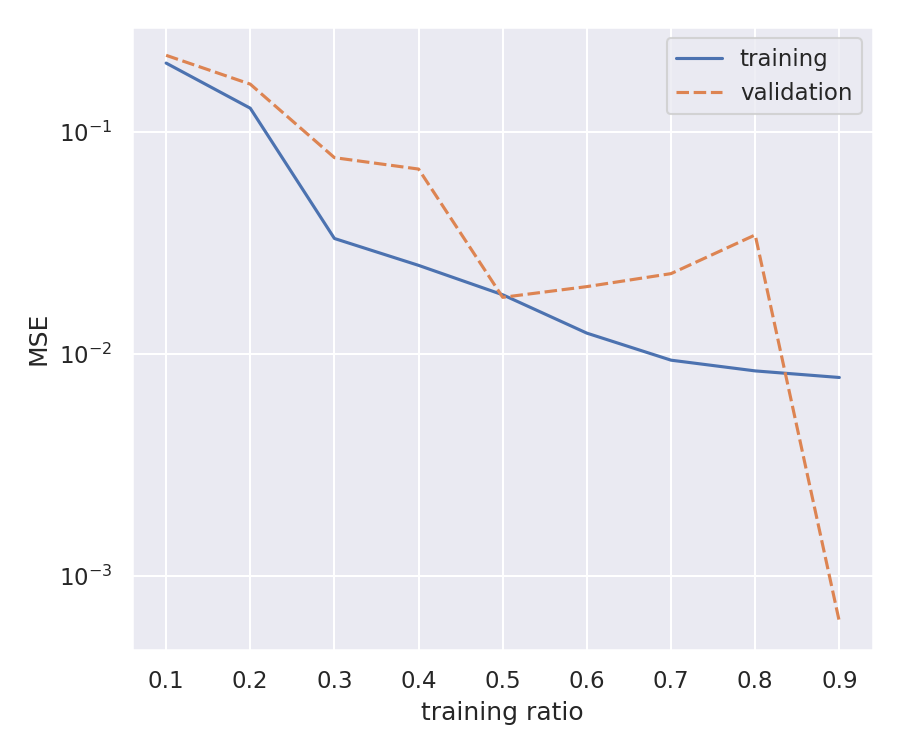

In [93]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Artificial Neural Networks

As a final model we use a simple fully connected (FC) ANN to predict the labels. We first build the model (it should not be too complicated, thus we can actually use the `Sequential` interface in `tf.keras`).

In [189]:
input_shape=(19,)

In [190]:
from tensorflow       import keras
from tensorflow.keras import layers, \
                             initializers, \
                             optimizers, \
                             regularizers, \
                             losses, \
                             metrics
from sklearn.metrics  import mean_squared_error, \
                             mean_absolute_error, \
                             r2_score


from tensorflow.keras.models import save_model

# clear leftover sessions
keras.backend.clear_session()

# build shortcuts to include layers
inputer  = lambda n: layers.Dense(n,
                         input_shape=input_shape,
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.20)
                        )
denser   = lambda n: layers.Dense(n,
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )
dropper  = lambda x: layers.Dropout(rate=x, seed=RAND)
outputer = lambda n: layers.Dense(n,
                         name='output',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )

# build the model
ann_mod = keras.Sequential(name='sft-trunc')

ann_mod.add(inputer(30))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.01))

ann_mod.add(denser(20))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.01))

ann_mod.add(denser(20))
ann_mod.add(layers.BatchNormalization())

ann_mod.add(denser(10))
ann_mod.add(layers.BatchNormalization())

ann_mod.add(outputer(1))

# compile the model
ann_mod.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss='mse',
                metrics=['mse', 'mae']
               )

ann_mod.summary()

# save the model
ANN_MODEL = './models/ann.h5'
save_model(ann_mod, ANN_MODEL)

Model: "sft-trunc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                600       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                42

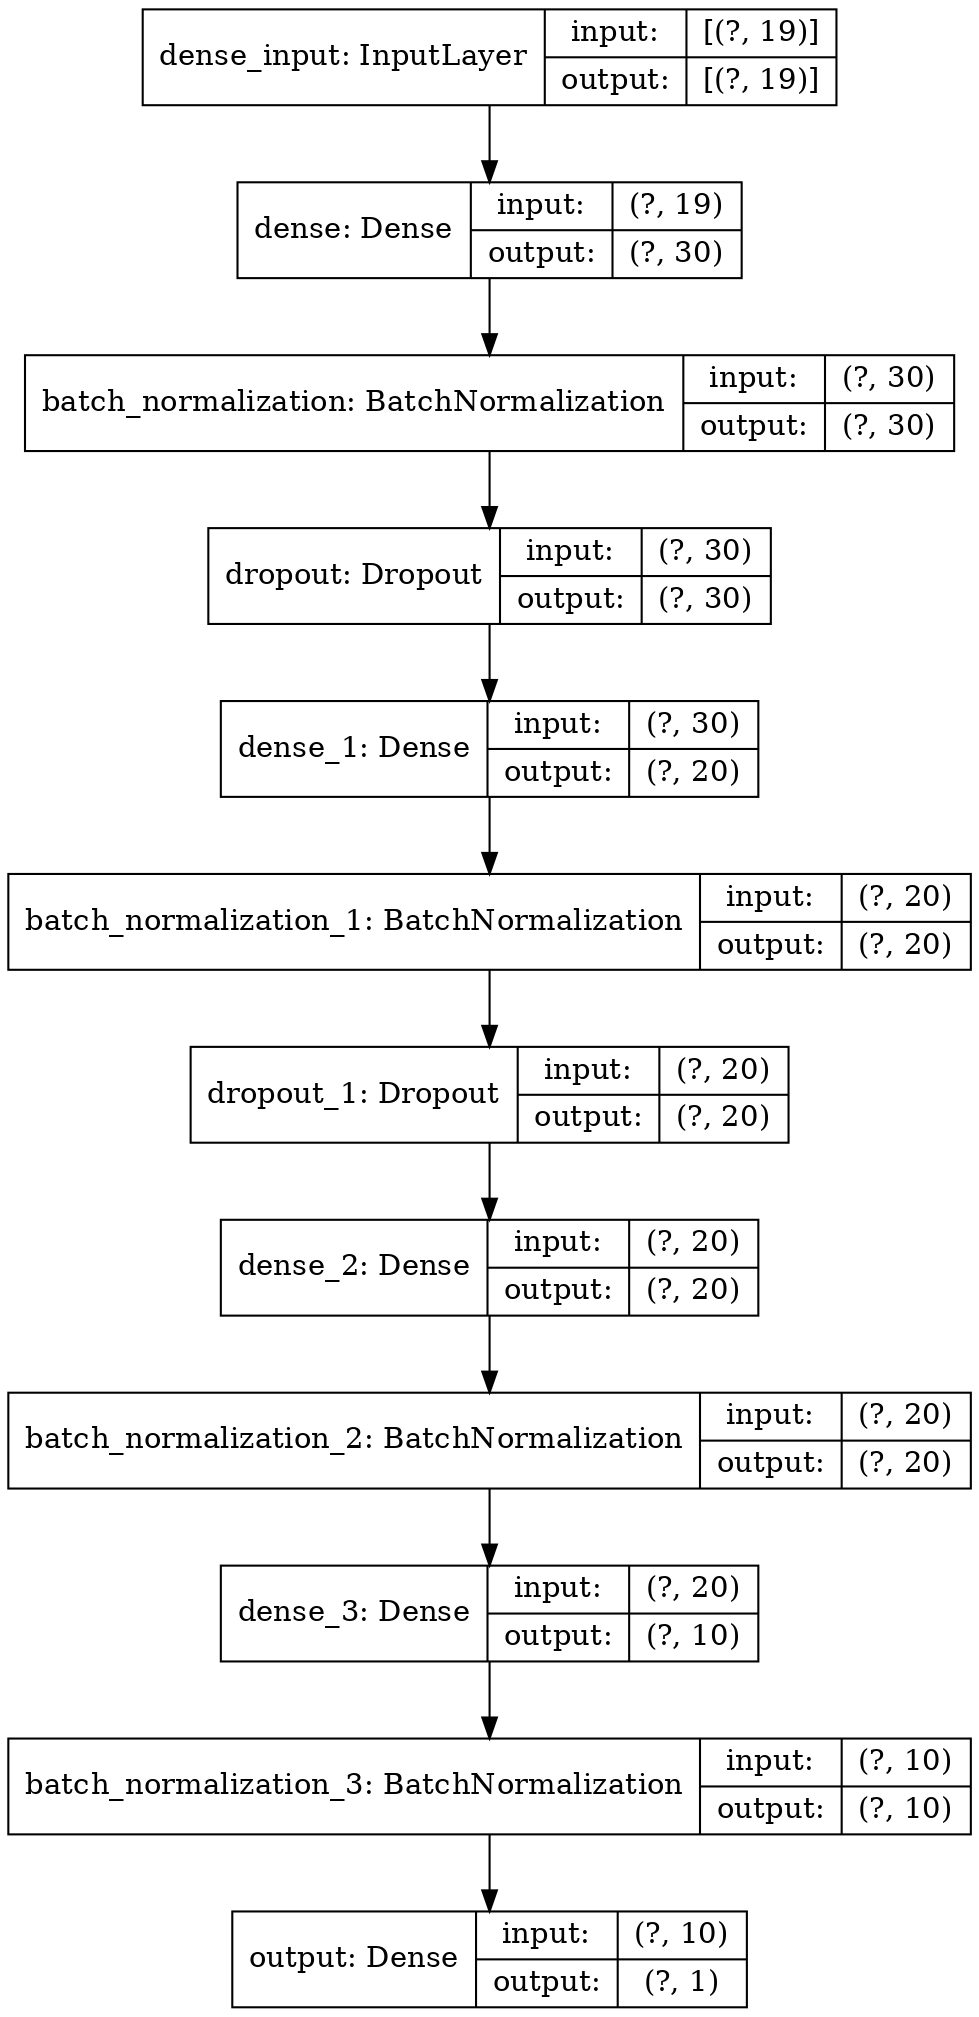

In [191]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

ann_mod_dot = model_to_dot(ann_mod, show_shapes=True, dpi=150)
ann_mod_dot.write_pdf('./img/ann_mod_arch.pdf')

Image(ann_mod_dot.create_png(), width=480)

We then fit the model on the data:

In [192]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'

ANN_MODEL = './models/ann.h5'
EPOCHS    = 25000
BATCH     = 32
EARLYSTOP = 5000
PLATEAU   = 2500

RAND = 123

!python3 ./scripts/keras-train.py -t {TRAIN} -lt {LAB_TRAIN} \
                                  -v {VAL} -lv {LAB_VAL} \
                                  -e {EPOCHS} -b {BATCH} \
                                  -s {EARLYSTOP} -p {PLATEAU} \
                                  -m {ANN_MODEL} -r {RAND}

Model trained in 711.718 seconds.


Finally we compute metrics and predictions:

In [193]:
TEST = './data/test.csv'
LAB_TEST = './data/lab_test.csv'

ANN_MODEL = './models/ann.h5'

OUTPUT_TRAIN = 'ann_model_train'
OUTPUT_VAL   = 'ann_model_val'
OUTPUT_TEST  = 'ann_model_test'

!python3 ./scripts/keras-predict.py -t {TRAIN} -l {LAB_TRAIN} -m {ANN_MODEL} -o {OUTPUT_TRAIN}
!python3 ./scripts/keras-predict.py -t {VAL} -l {LAB_VAL} -m {ANN_MODEL} -o {OUTPUT_VAL}
!python3 ./scripts/keras-predict.py -t {TEST} -l {LAB_TEST} -m {ANN_MODEL} -o {OUTPUT_TEST}

Model predicted in 0.276 seconds.
Model predicted in 0.262 seconds.
Model predicted in 0.260 seconds.


In [194]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ann_model_train,554,0.002617,-0.000842,0.006077,0.051160,0.008488,0.994761
ann_model_val,48,0.000022,0.000014,0.000029,0.004657,0.003958,0.999955
ann_model_test,59,0.000037,0.000019,0.000055,0.006074,0.004758,0.999927


Finally we produce all the necessary plots and display them:

In [195]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'ann_model_val'
OUTPUT_TEST = 'ann_model_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

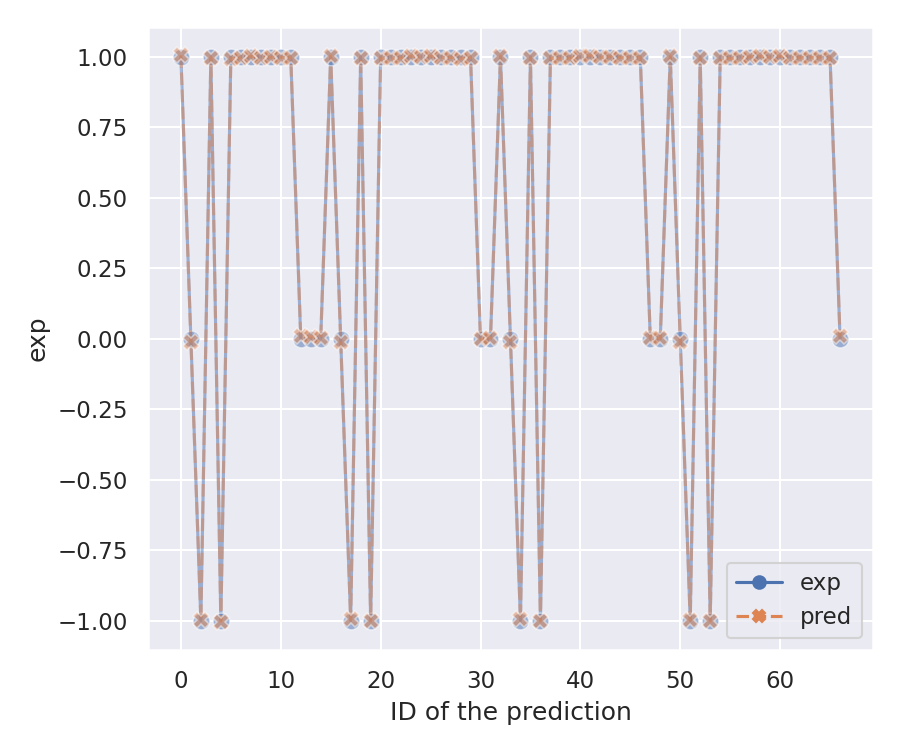

In [196]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

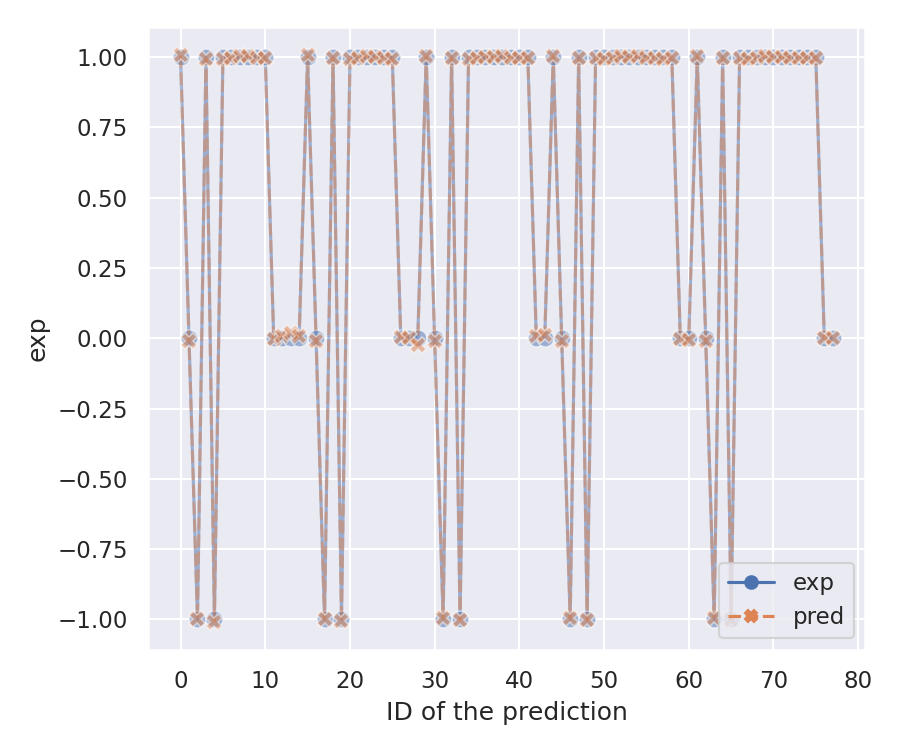

In [197]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

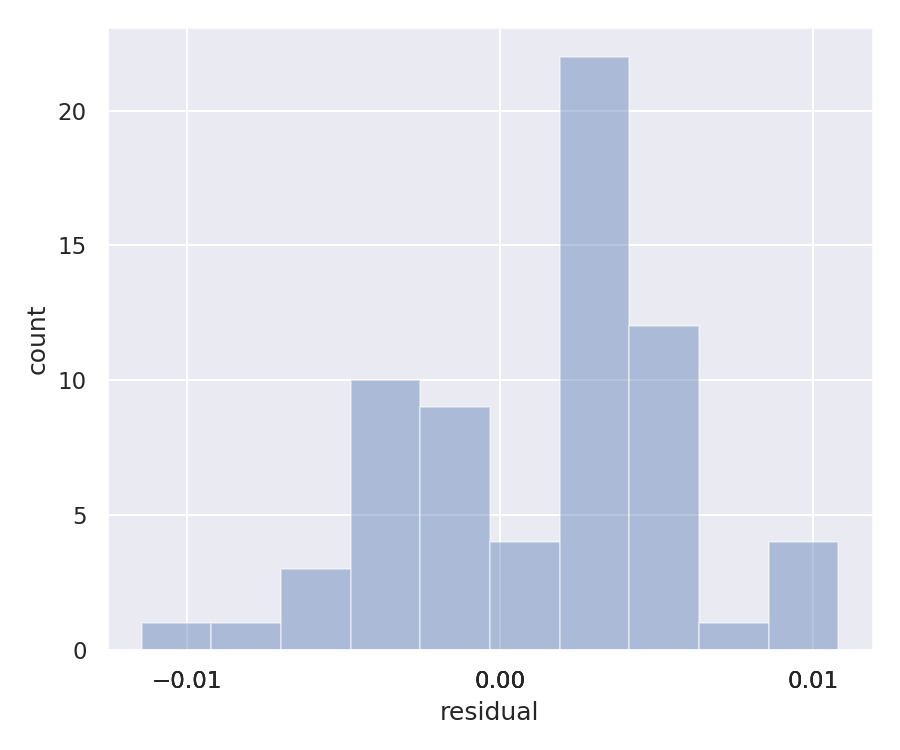

In [198]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

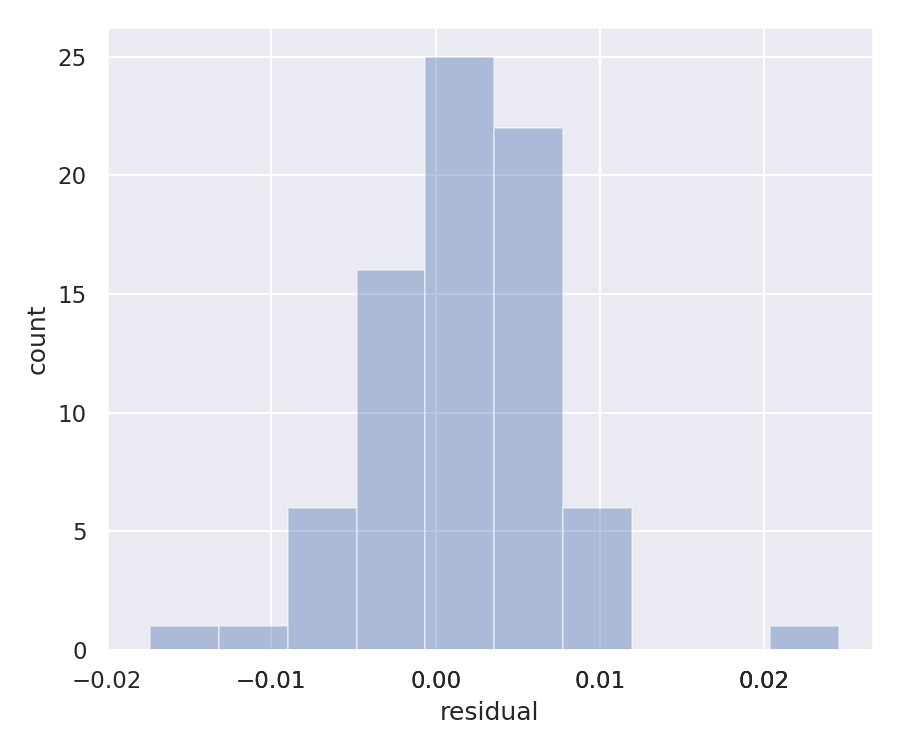

In [199]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

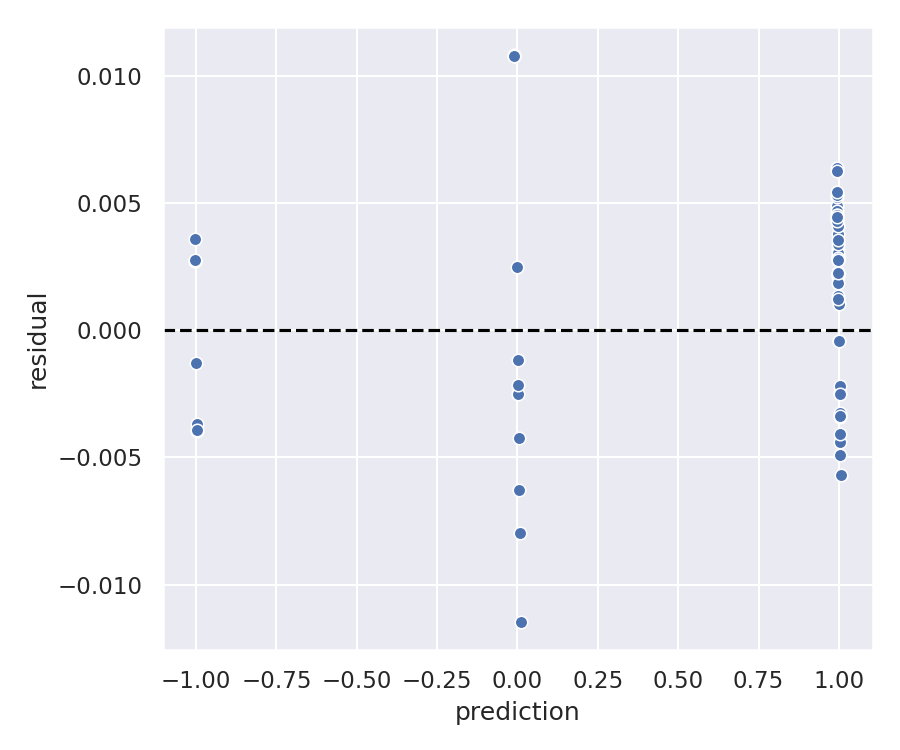

In [200]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

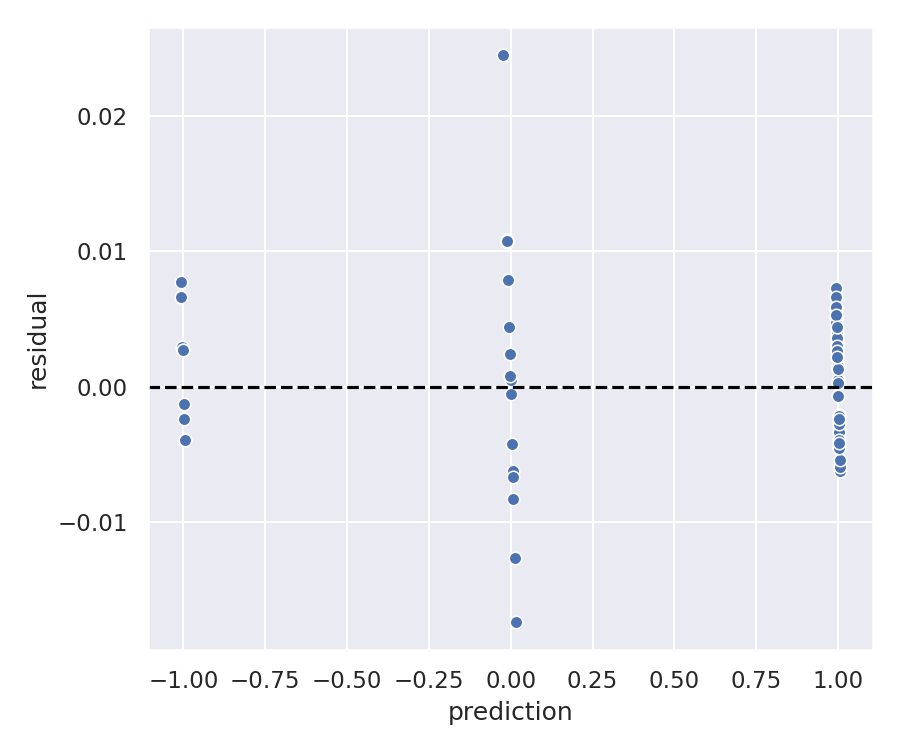

In [201]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

In [202]:
HISTORY = './models/ann_mod_hst.json'
OUTPUT  = 'ann_mod_hst'

!python3 ./scripts/keras-history.py --data {HISTORY} --output {OUTPUT}

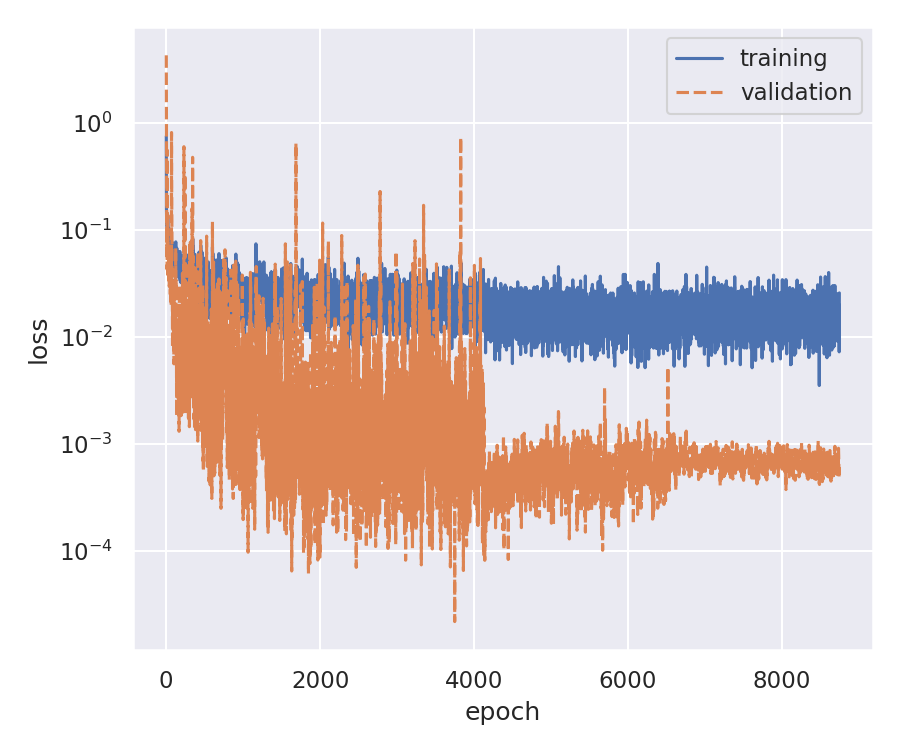

In [203]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

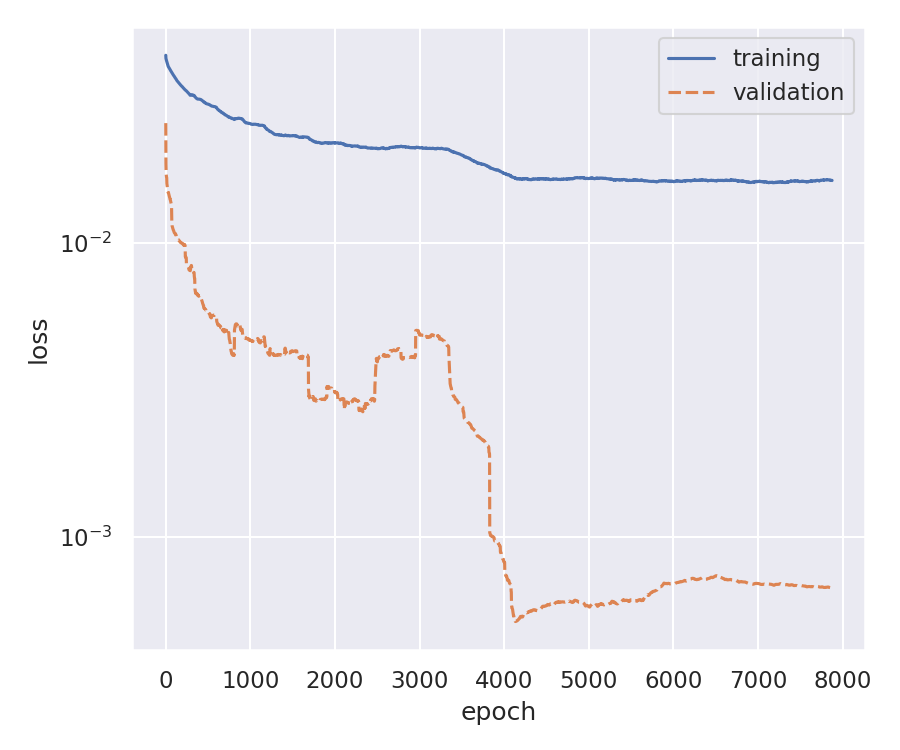

In [204]:
from IPython.display import Image
Image('./img/{}_avg.png'.format(OUTPUT), width=480)

We finally take a look at the learning curve:

In [205]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'ann_mod_lc'

!python3 ./scripts/keras-lc.py -d {DATA} -m {ANN_MODEL} -e {EPOCHS} -b {BATCH} -s {EARLYSTOP} -p {PLATEAU} -o {OUTPUT}

Trained ratio 0.10 in 280.310 seconds.
Trained ratio 0.20 in 536.646 seconds.
Trained ratio 0.30 in 324.861 seconds.
Trained ratio 0.40 in 430.786 seconds.
Trained ratio 0.50 in 827.579 seconds.
Trained ratio 0.60 in 630.171 seconds.
Trained ratio 0.70 in 686.432 seconds.
Trained ratio 0.80 in 465.884 seconds.
Trained ratio 0.90 in 864.759 seconds.
Learning curve trained in 5049.664 seconds.


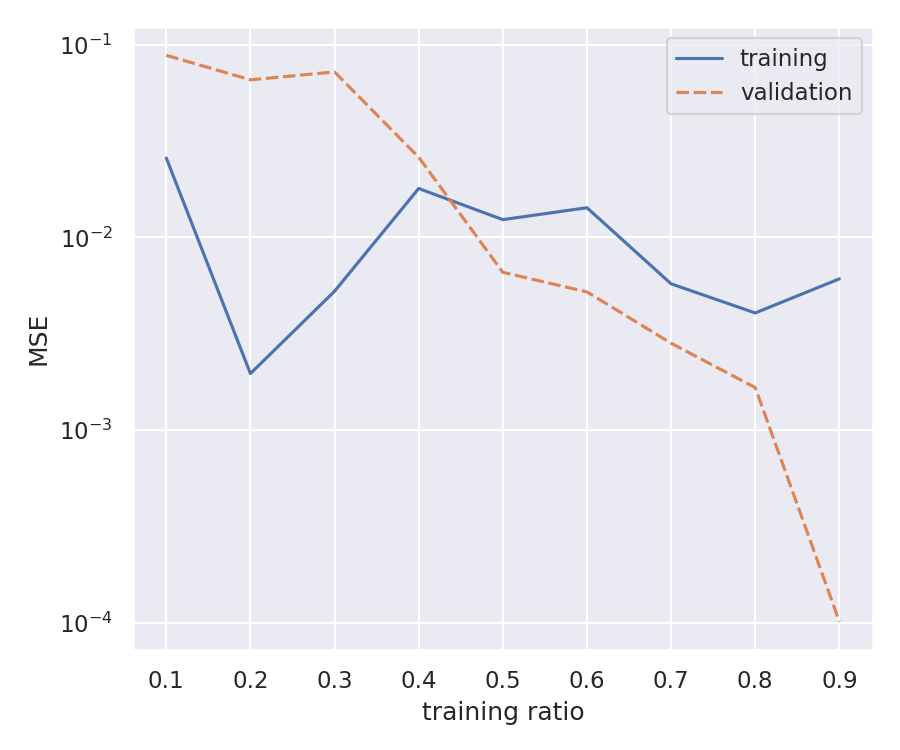

In [206]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Aggregate

For simplicity reload all the metrics and show in a table the results:

In [3]:
import json
import numpy as np
import pandas as pd

with open('./metrics/ridge_train.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_train.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_train.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_train.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_train.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_train.json', 'r') as f:
    ann = json.load(f)
    
metrics_train = {'MSE':    [np.round(m['MSE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 3), np.round(m['MSE 95% CI (upper)'], 3)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_train = pd.DataFrame(metrics_train, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [4]:
print('Training metrics:\n')
metrics_train.to_csv('./metrics/train_summary.csv')
metrics_train

Training metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.175,"(0.134, 0.216)",0.418,0.306,0.650
l-SVR,2.475,"(1.239, 3.711)",1.573,0.477,-3.953
r-SVR,0.045,"(0.021, 0.069)",0.213,0.080,0.909
RF,0.024,"(0.013, 0.035)",0.154,0.043,0.953
GBDT,0.006,"(0.002, 0.009)",0.075,0.024,0.989
ANN,0.003,"(-0.001, 0.006)",0.051,0.008,0.995


In [5]:
import json
import numpy as np
import pandas as pd

with open('./metrics/ridge_val.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_val.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_val.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_val.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_val.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_val.json', 'r') as f:
    ann = json.load(f)
    
metrics_val = {'MSE':    [np.round(m['MSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 5), np.round(m['MSE 95% CI (upper)'], 5)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_val = pd.DataFrame(metrics_val, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [7]:
print('Validation metrics:\n')
metrics_val.to_csv('./metrics/val_summary.csv')
metrics_val

Validation metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.10786,"(0.06687, 0.14885)",0.32842,0.26840,0.77626
l-SVR,1.39160,"(-0.48978, 3.27297)",1.17966,0.38805,-1.88673
r-SVR,0.01297,"(-0.00136, 0.0273)",0.11389,0.06228,0.97309
RF,0.00354,"(-4e-05, 0.00711)",0.05947,0.02430,0.99266
GBDT,0.00016,"(9e-05, 0.00024)",0.01281,0.00877,0.99966
ANN,0.00002,"(1e-05, 3e-05)",0.00466,0.00396,0.99996


In [8]:
import json
import numpy as np
import pandas as pd

with open('./metrics/ridge_test.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_test.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_test.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_test.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_test.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_test.json', 'r') as f:
    ann = json.load(f)
    
metrics_test = {'MSE':    [np.round(m['MSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 5), np.round(m['MSE 95% CI (upper)'], 5)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_test = pd.DataFrame(metrics_test, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [9]:
print('Test metrics:\n')
metrics_test.to_csv('./metrics/test_summary.csv')
metrics_test

Test metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.16019,"(0.07349, 0.2469)",0.40024,0.29223,0.68357
l-SVR,2.41621,"(-0.24859, 5.081)",1.55442,0.48745,-3.77280
r-SVR,0.02557,"(0.00509, 0.04605)",0.15990,0.08070,0.94949
RF,0.01105,"(-0.00276, 0.02486)",0.10512,0.03662,0.97817
GBDT,0.00085,"(-0.00015, 0.00185)",0.02921,0.01590,0.99831
ANN,0.00004,"(2e-05, 5e-05)",0.00607,0.00476,0.99993
